In [3]:
import argparse
import os
import numpy as np

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="main.py")
    parser.add_argument("--working_data", type=str, default="working_data", help="The path to the directory that will contain trajectories.")
    parser.add_argument("--results", type=str, default="results", help="The path to the directory that will contain analysis results.")
    parser.add_argument("--ff_to_use", type=str, default="results", help="The path to the (off)xml force field file.")
    # parser.add_argument("--rng_seed", type=int, default=12345, help="The seed used for all OpenMM simulations in all windows for this run.")

    args = parser.parse_args()

    os.makedirs(args.working_data, exist_ok=True)
    os.makedirs(args.results, exist_ok=True)
    with open(f"{args.working_data}/RNG_SEED", "w") as f:
        f.write(str(np.random.randint(0, int(1e6))))
    working_data = args.working_data
    results_dirname = args.results
    FF_TO_USE = args.ff_to_use

usage: ipykernel_launcher.py [-h] [--working_data WORKING_DATA]
                             [--results RESULTS] [--ff_to_use FF_TO_USE]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/jta002/.local/share/jupyter/runtime/kernel-1ddda131-238e-47c4-a46f-6e5f942e1d48.json


SystemExit: 2

/home/jta002/miniconda3/envs/openff-evaluator-6/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [7]:
import itertools
import logging
import pickle
import shutil
import sys
from copy import deepcopy
from importlib import reload
import xmltodict

import numpy as np
import parmed as pmd
import ray
from openff.toolkit import ForceField as openffForceField
from openff.toolkit import Molecule as openffMolecule
from openff.toolkit import Topology as openffTopology
from openff.units import unit as openff_unit
from openmmforcefields.generators import (
    GAFFTemplateGenerator,
    SMIRNOFFTemplateGenerator,
)
from rdkit import Chem
from tqdm import tqdm

from openmm import *
from openmm.app import *
from openmm.unit import *

# os.environ["NUMEXPR_MAX_THREADS"] = "8"
os.environ["OE_LICENSE"] = os.environ["HOME"] + "oe_license.txt"


# ray.init(dashboard_port=8838, log_to_driver=True, logging_level="warning")

reload(logging)
logger = logging.getLogger("PL_ABFE-BRD4")
logging.basicConfig(
    format="%(asctime)s %(message)s", datefmt="%Y-%m-%d %I:%M:%S %p", level=logging.INFO
)
stream_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stream_handler)

RUN_IN_NOTEBOOK = False

if RUN_IN_NOTEBOOK:
    working_data = "working_data"
    results_dirname = "results"
    FF_TO_USE = "../force_fields/GBSA-OBC2.offxml"

initial_data = "initial_data"
prepared_data = "prepared_data"

data_dir_names = {
    "initial_data": initial_data,
    "prepared_data": prepared_data,
    "working_data": working_data,
    "results": results_dirname,
}

In [8]:
def add_CustomGB_force(xml_filename: str, system: openmm.System):
    with open(xml_filename, "r") as f:
        ff_xml = f.read()
    ff_dict = xmltodict.parse(ff_xml)
    
    gb_force = openmm.CustomGBForce()
    gb_force.addPerParticleParameter("q")
    gb_force.addPerParticleParameter("radius")
    gb_force.addPerParticleParameter("scale")
    gb_force.addPerParticleParameter("isntDummy")
    gb_force.addGlobalParameter("solventDielectric", float(ff_dict["SMIRNOFF"]["CustomGBSA"]["@solvent_dielectric"]))
    gb_force.addGlobalParameter("soluteDielectric", float(ff_dict["SMIRNOFF"]["CustomGBSA"]["@solute_dielectric"]))
    gb_force.addGlobalParameter("surface_area_penalty", 5.4)
    gb_force.addGlobalParameter("solvent_radius", 0.14)
    gb_force.addGlobalParameter("kappa", 0.0)
    gb_force.addGlobalParameter("PI", float(np.pi))
    gb_force.addGlobalParameter("ONE_4PI_EPS0", 138.935485)
    
    gb_force.addComputedValue("I", "select(step(r+sr2-or1), 0.5*(1/L-1/U+0.25*(r-sr2^2/r)*(1/(U^2)-1/(L^2))+0.5*log(L/U)/r), 0);"
                                  "U=r+sr2;"
                                  "C=2*(1/or1-1/L)*step(sr2-r-or1);"
                                  "L=max(or1, D);"
                                  "D=abs(r-sr2);"
                                  "sr2 = scale2*or2;"
                                  "or1 = radius1-0.009; or2 = radius2-0.009", CustomGBForce.ParticlePairNoExclusions)

    if ff_dict["SMIRNOFF"]["CustomGBSA"]["@gb_model"] == "OBC":
        gb_force.addComputedValue("B", f"1/(1/or-tanh({float(ff_dict['SMIRNOFF']['CustomGBSA']['@alpha'])}*psi-{float(ff_dict['SMIRNOFF']['CustomGBSA']['@beta'])}*psi^2+{float(ff_dict['SMIRNOFF']['CustomGBSA']['@gamma'])}*psi^3)/radius);"
                                      "psi=I*or; or=radius-0.009", CustomGBForce.SingleParticle)

    elif ff_dict["SMIRNOFF"]["CustomGBSA"]["@gb_model"] == "OBC_Logistic":
        gb_force.addComputedValue("B", "logistic_curve; "
                                  f"logistic_curve=(A+(K-A)/((1+nu*exp(b*(inflec-(psi))))^(1/nu))); "
                                  f"A=radius; K=((or)^(-1) - (radius)^(-1))^(-1); nu={float(ff_dict['SMIRNOFF']['CustomGBSA']['@nu'])}; b={float(ff_dict['SMIRNOFF']['CustomGBSA']['@b'])}; inflec={float(ff_dict['SMIRNOFF']['CustomGBSA']['@inflec'])}; "
                                  f"psi=I*or; or=radius-0.009;", CustomGBForce.SingleParticle)

    gb_force.addEnergyTerm("-0.5*ONE_4PI_EPS0*(1/soluteDielectric-1/solventDielectric)*q^2/B", CustomGBForce.SingleParticle)
    gb_force.addEnergyTerm("4*PI*surface_area_penalty*(radius+solvent_radius)^2*(radius/B)^6;", openmm.CustomGBForce.SingleParticle)
    gb_force.addEnergyTerm("-ONE_4PI_EPS0*(1/soluteDielectric-1/solventDielectric)*q1*q2/f;"
                          "f=sqrt(r^2+B1*B2*exp(-r^2/(4*B1*B2)))", CustomGBForce.ParticlePairNoExclusions);
    
    matches = []
    for smirks_dict in ff_dict["SMIRNOFF"]["CustomGBSA"]["Atom"]:
        matches.append([match[0] for match in protein_mol.chemical_environment_matches(smirks_dict["@smirks"])] + [match[0] + protein_mol.n_atoms for match in ligand_mol.chemical_environment_matches(smirks_dict["@smirks"])])
    
    for i, atom in enumerate(openff_topology.atoms):
        for j, match_list in enumerate(matches):
            if i in match_list:
                specific_atom_data = ff_dict["SMIRNOFF"]["CustomGBSA"]["Atom"][j]
        q = atom.partial_charge.m_as(openff_unit.elementary_charge)
        radius = float(specific_atom_data["@radius"].split("*")[0])
        scale = float(specific_atom_data["@scale"])
        isnt_dummy = 1
        gb_force.addParticle((q, radius, scale, isnt_dummy))
    
    system.addForce(gb_force);

## Prepare the system

In [9]:
def create_protein_mol():
    # Load ff14SB to assign charges to the protein
    ff14SB = ForceField("amber/ff14SB.xml")
    protein_pdb = PDBFile(f"{prepared_data}/4lys_protonated_vacuum.pdb")
    protein_system = ff14SB.createSystem(protein_pdb.topology)

    # Get ff14SB-assigned charges into a list
    protein_atomic_charges = np.zeros(protein_pdb.topology.getNumAtoms())
    for force in protein_system.getForces():
        if isinstance(force, NonbondedForce):
            for i, atom in enumerate(protein_pdb.topology.atoms()):
                # print(force.getParticleParameters(i)[0], type(force.getParticleParameters(i)[0]))
                protein_atomic_charges[i] = force.getParticleParameters(i)[0].value_in_unit(elementary_charge)

    # Make sum of all partial charges integer by adding/subtracting the nonintegral charge / N_atoms
    # for each atom
    difference = round(sum(protein_atomic_charges)) - sum(protein_atomic_charges)
    difference_per_atom = difference / protein_pdb.topology.getNumAtoms()
    protein_atomic_charges += difference_per_atom

    
    # A little rdkit sanitization is necessary: we need to generate formal charges
    protein_rdkit_mol = Chem.MolFromMolFile(
        f"{prepared_data}/4lys_protonated_vacuum.sdf", sanitize=False
    )
    for atom in protein_rdkit_mol.GetAtoms():
        if atom.GetSymbol() == "N" and atom.GetExplicitValence() == 4:
            atom.SetFormalCharge(1)
    Chem.SanitizeMol(protein_rdkit_mol)
    Chem.MolToMolFile(
        protein_rdkit_mol, f"{prepared_data}/4lys_protonated_vacuum_clean.sdf"
    )

    protein_mol = openffMolecule.from_file(
        f"{prepared_data}/4lys_protonated_vacuum_clean.sdf"
    )

    # When translated to OpenFF Molecule, we have 13 extra hydrogens for some reason,
    # so here we create a new molecule that doesn't have these extra Hs.
    # The way we do this assumes all of the extraneous Hs are at the end of the atoms list
    protein_mol_new = openffMolecule()
    protein_mol_new.name = "4LYS"

    for i in range(protein_pdb.topology.getNumAtoms()):
        atom = protein_mol.atoms[i]
        metadata = {
            "residue_name": list(protein_pdb.topology.atoms())[i].residue.name,
            "residue_number": list(protein_pdb.topology.atoms())[i].residue.id,
        }
        protein_mol_new.add_atom(
            atom.atomic_number,
            atom.formal_charge,
            atom.is_aromatic,
            stereochemistry=atom.stereochemistry,
            name=list(protein_pdb.topology.atoms())[i].name,
            metadata=metadata,
        )

    # Add bonds to the new molecule
    for bond in protein_mol.bonds:
        if (
            bond.atom1_index < protein_pdb.topology.getNumAtoms()
            and bond.atom2_index < protein_pdb.topology.getNumAtoms()
        ):
            protein_mol_new.add_bond(
                bond.atom1_index,
                bond.atom2_index,
                bond.bond_order,
                bond.is_aromatic,
                stereochemistry=bond.stereochemistry,
                fractional_bond_order=bond.fractional_bond_order,
            )

    # Add conformer
    protein_mol_new.add_conformer(
        coordinates=protein_mol.conformers[0][: protein_pdb.topology.getNumAtoms(), :]
    )

    del protein_mol
    protein_mol = protein_mol_new
    assert protein_mol.n_atoms == protein_pdb.topology.getNumAtoms()
    assert protein_mol.n_bonds == protein_pdb.topology.getNumBonds()

    # Assign ff14SB charges to the OpenFF Molecule
    protein_mol.partial_charges = protein_atomic_charges * openff_unit.elementary_charge
    # protein_mol.generate_unique_atom_names()

    sys.setrecursionlimit(10000)
    with open(f"{prepared_data}/protein_mol.pickle", "wb") as f:
        pickle.dump(protein_mol, f)

    return protein_mol


try:
    with open(f"{prepared_data}/protein_mol.pickle", "rb") as f:
        protein_mol = pickle.load(f)
except:
    protein_mol = create_protein_mol()

In [10]:
def create_ligand_mol():
    ligand_mol = openffMolecule.from_file(
        f"{prepared_data}/4lys_D_2SJ_protonated_vacuum.mol2", file_format="mol2"
    )
    ligand_mol.assign_partial_charges(
        partial_charge_method="am1bcc", use_conformers=ligand_mol.conformers
    )
    for atom in ligand_mol.atoms:
        atom.metadata["residue_name"] = "2SJ"

    sys.setrecursionlimit(10000)
    with open(f"{prepared_data}/ligand_mol.pickle", "wb") as f:
        pickle.dump(ligand_mol, f)

    return ligand_mol


try:
    with open(f"{prepared_data}/ligand_mol.pickle", "rb") as f:
        ligand_mol = pickle.load(f)
except:
    ligand_mol = create_ligand_mol()

In [11]:
implicit_solvent = True

if implicit_solvent:
    force_field = openffForceField(
        "openff-2.2.0.offxml",
        "ff14sb_off_impropers_0.0.4.offxml",  # Consider removing openff impropers -Chapin
        load_plugins=True,
        allow_cosmetic_attributes=True,
    )
    
    openff_topology = openffTopology.from_molecules(molecules=[protein_mol, ligand_mol])
    # openff_topology = openffTopology.from_pdb(f"{prepared_data}/4lys_protonated_vacuum.pdb")
    # openff_topology.add_molecule(ligand_mol)
    
    system = force_field.create_openmm_system(
        openff_topology,
        partial_bond_orders_from_molecules=[protein_mol, ligand_mol],
        charge_from_molecules=[protein_mol, ligand_mol],
        allow_nonintegral_charges=True,
    )

    add_CustomGB_force(FF_TO_USE, system)
    
    openmm_positions = Quantity(
        value=[
            Vec3(
                pos[0].m_as(openff_unit.nanometer),
                pos[1].m_as(openff_unit.nanometer),
                pos[2].m_as(openff_unit.nanometer),
            )
            for pos in openff_topology.get_positions()
        ],
        unit=nanometer,
    )
    model = Modeller(
        openff_topology.to_openmm(ensure_unique_atom_names=False), openmm_positions
    )

else:
    from openmmforcefields.generators import (
        GAFFTemplateGenerator,
    )
    
    gaff = GAFFTemplateGenerator(molecules=ligand_mol)
    
    forcefield = ForceField(
        "amber/protein.ff14SB.xml",
        "amber/tip3p_standard.xml",
        "amber/tip3p_HFE_multivalent.xml",
    )
    forcefield.registerTemplateGenerator(gaff.generator)

In [12]:
from paprika.build import align

structure = pmd.openmm.load_topology(
    model.topology,
    system,
    xyz=openmm_positions,
    condense_atom_types=False,
)

A1 = ":2SJ@C5"  # ":2SJ@C10x"
A2 = ":2SJ@C22"  # ":2SJ@C16x"

align.translate_to_origin(structure)
align.zalign(structure, A1, A2)

2025-06-21 02:24:22 PM Moving :2SJ@C5 (1 atoms) to the origin...
2025-06-21 02:24:22 PM Aligning :2SJ@C22 (1 atoms) with the z axis...


<Structure 2131 atoms; 125 residues; 2163 bonds; parameterized>

In [13]:
P1 = f":{110-42}@CA"  # ":ILE@C365x"
P2 = f":{131-42}@CA"  # ":THR@C485x"
P3 = f":{157-42}@CA"  # ":PHE@C619x"

L1 = ":2SJ@O3"  # ":2SJ@O4x"
L2 = ":2SJ@C10"  # ":2SJ@C6x"
L3 = ":2SJ@C19"  # ":2SJ@C19x"

In [14]:
# Ensure that P1 lies on the YZ plane
P1_original = structure[P1].coordinates[0]
P1_rotated = np.array([0, np.linalg.norm(P1_original[:2]), P1_original[2]])

theta_initial = np.arctan2(P1_original[1], P1_original[0])
theta_final = np.arctan2(P1_rotated[1], P1_rotated[0])

# Calculate the rotation angle in radians
delta_theta = theta_final - theta_initial
align.rotate_around_axis(structure, "z", delta_theta)

with open(f"{prepared_data}/aligned_structure.pickle", "wb") as f:
    pickle.dump(deepcopy(structure), f)

# Make sure that the new x coordinate of P1 is close to 0
print(f"The new x coordinate of P1 is: {structure[P1].coordinates[0][0]:0.3f}")

model = Modeller(model.topology, structure.positions.in_units_of(nanometer))

# N1_pos is same x and y as L1, but 5 Angstroms less in z   NOTE: 3/30/2025 testing this manually set to 7 A less
N1_pos = Quantity(
    value=Vec3(
        0, 0, (structure[L1].positions[0][2] - 5 * angstroms).value_in_unit(nanometer)
    ),
    unit=nanometer,
)
# N2_pos is same x and z as N1_pos, but with a y value equal to to the y value of P1
N2_pos = Quantity(
    value=Vec3(
        0,
        structure[P1].positions[0][1].value_in_unit(nanometer),
        N1_pos[2].value_in_unit(nanometer),
    ),
    unit=nanometer,
)

N3_pos = Quantity(
    value=Vec3(
        0,
        N2_pos[1].value_in_unit(nanometer),
        (N2_pos[2] + (N2_pos[2] - structure[P1].positions[0][2])).value_in_unit(
            nanometer
        ),
    ),
    unit=nanometer,
)

The new x coordinate of P1 is: 0.000


In [15]:
# Give the dummy atoms mass of lead (207.2) and set the nonbonded forces for the dummy atoms to have charge 0 and LJ parameters epsilon=sigma=0.
for force in system.getForces():
    if isinstance(force, openmm.NonbondedForce):
        system.addParticle(mass=207.2)
        system.addParticle(mass=207.2)
        system.addParticle(mass=207.2)
        force.addParticle(0, 0, 0)
        force.addParticle(0, 0, 0)
        force.addParticle(0, 0, 0)
    if isinstance(force, openmm.CustomGBForce):
        force.addParticle([0, 0.15, 0.7, 0])
        force.addParticle([0, 0.15, 0.7, 0])
        force.addParticle([0, 0.15, 0.7, 0])

with open(f"{prepared_data}/aligned_dummy_system.xml", "w") as f:
    f.write(XmlSerializer.serialize(system))

all_positions = model.positions
all_positions.append(N1_pos)
all_positions.append(N2_pos)
all_positions.append(N3_pos)

chain = model.topology.addChain("5")
dummy_res1 = model.topology.addResidue(name="DM1", chain=chain, id="500")
dummy_res2 = model.topology.addResidue(name="DM2", chain=chain, id="501")
dummy_res3 = model.topology.addResidue(name="DM3", chain=chain, id="502")

model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res1)
model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res2)
model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res3)

with open(f"{prepared_data}/aligned_dummy_structure.cif", "w+") as f:
    PDBxFile.writeFile(model.topology, all_positions, file=f, keepIds=True)
with open(f"{prepared_data}/aligned_dummy_structure.pdb", "w+") as f:
    PDBFile.writeFile(model.topology, all_positions, file=f, keepIds=True)

aligned_dummy_structure = pmd.openmm.load_topology(
    model.topology, system, xyz=all_positions, condense_atom_types=False
)

In [16]:
N1 = ":DM1@DUM"
N2 = ":DM2@DUM"
N3 = ":DM3@DUM"

ASP88_1 = f":{88-42}@N"  # Asp88 N
ASP88_2 = f":{88-42}@CA"  # Asp88 C_alpha
ASP88_3 = f":{88-42}@C"  # Asp88 C
ASP88_4 = f":{89-42}@N"  # Ala89 N

In [17]:
for mask in [
    A1,
    A2,
    P1,
    P2,
    P3,
    L1,
    L2,
    L3,
    N1,
    N2,
    N3,
    ASP88_1,
    ASP88_2,
    ASP88_3,
    ASP88_4,
]:
    try:
        assert len(aligned_dummy_structure[mask].positions) == 1
    except:
        print(mask)

In [18]:
deltaG_values = {}

## Calculate $\Delta G_{attach,p}$

In [13]:
from paprika import restraints
from paprika.restraints.openmm import apply_dat_restraint, apply_positional_restraints

# Generate lambda values with diffs growing exponentially
K = 48   # Total number of windows
i = np.arange(K)
attach_p_fractions = 1 - np.exp(-3 * i / (K - 1))
attach_p_fractions /= attach_p_fractions[-1]  # Normalize to make the last value 1.0
# attach_p_fractions = np.round(1 - attach_p_fractions[::-1], decimals=6)
attach_p_fractions = 1 - attach_p_fractions[::-1]

attach_p_restraints_static = []


Asp88_torsion_wall_static = restraints.static_DAT_restraint(
    [ASP88_1, ASP88_2, ASP88_3, ASP88_4],
    [len(attach_p_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
Asp88_torsion_wall_static.custom_restraint_values = {
    "r2": 55.0 * openff_unit.degree,
    "r3": 179.9,
    "rk2": 20.0 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    "rk3": 0.0,
}

attach_p_restraints_static.append(Asp88_torsion_wall_static)

attach_p_restraints_dynamic = []


P1_P2_distance = restraints.DAT_restraint()
P1_P2_distance.mask1 = P1
P1_P2_distance.mask2 = P2
P1_P2_distance.topology = aligned_dummy_structure
P1_P2_distance.auto_apr = False
P1_P2_distance.continuous_apr = False
P1_P2_distance.amber_index = False
P1_P2_vector = (
    aligned_dummy_structure[P2].positions[0] - aligned_dummy_structure[P1].positions[0]
)
P1_P2_vector = [val.value_in_unit(angstrom) for val in P1_P2_vector]
P1_P2_distance.attach["target"] = openff_unit.Quantity(
    value=np.linalg.norm(P1_P2_vector), units=openff_unit.angstrom
)
P1_P2_distance.attach["fraction_list"] = attach_p_fractions * 100
P1_P2_distance.attach["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
P1_P2_distance.initialize()

attach_p_restraints_dynamic.append(P1_P2_distance)


P2_P3_distance = restraints.DAT_restraint()
P2_P3_distance.mask1 = P2
P2_P3_distance.mask2 = P3
P2_P3_distance.topology = aligned_dummy_structure
P2_P3_distance.auto_apr = False
P2_P3_distance.continuous_apr = False
P2_P3_distance.amber_index = False
P2_P3_vector = (
    aligned_dummy_structure[P3].positions[0] - aligned_dummy_structure[P2].positions[0]
)
P2_P3_vector = [val.value_in_unit(angstrom) for val in P2_P3_vector]
P2_P3_distance.attach["target"] = openff_unit.Quantity(
    value=np.linalg.norm(P2_P3_vector), units=openff_unit.angstrom
)
P2_P3_distance.attach["fraction_list"] = attach_p_fractions * 100
P2_P3_distance.attach["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
P2_P3_distance.initialize()

attach_p_restraints_dynamic.append(P2_P3_distance)


P1_P3_distance = restraints.DAT_restraint()
P1_P3_distance.mask1 = P1
P1_P3_distance.mask2 = P3
P1_P3_distance.topology = aligned_dummy_structure
P1_P3_distance.auto_apr = False
P1_P3_distance.continuous_apr = False
P1_P3_distance.amber_index = False
P1_P3_vector = (
    aligned_dummy_structure[P3].positions[0] - aligned_dummy_structure[P1].positions[0]
)
P1_P3_vector = [val.value_in_unit(angstrom) for val in P1_P3_vector]
P1_P3_distance.attach["target"] = openff_unit.Quantity(
    value=np.linalg.norm(P1_P3_vector), units=openff_unit.angstrom
)
P1_P3_distance.attach["fraction_list"] = attach_p_fractions * 100
P1_P3_distance.attach["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
P1_P3_distance.initialize()

attach_p_restraints_dynamic.append(P1_P3_distance)


Asp88_torsion = restraints.DAT_restraint()
Asp88_torsion.mask1 = ASP88_1
Asp88_torsion.mask2 = ASP88_2
Asp88_torsion.mask3 = ASP88_3
Asp88_torsion.mask4 = ASP88_4
Asp88_torsion.topology = aligned_dummy_structure
Asp88_torsion.auto_apr = False
Asp88_torsion.continuous_apr = False
Asp88_torsion.amber_index = False
Asp88_torsion.attach["target"] = 80  # Degrees
Asp88_torsion.attach["fraction_list"] = attach_p_fractions * 100
Asp88_torsion.attach["fc_final"] = 30  # kilocalorie/(mole*radian**2)
Asp88_torsion.initialize()

attach_p_restraints_dynamic.append(Asp88_torsion)


# Check restraints and create windows from dynamic restraints
restraints.restraints.check_restraints(attach_p_restraints_static)
restraints.restraints.check_restraints(attach_p_restraints_dynamic)
window_list = restraints.utils.create_window_list(attach_p_restraints_dynamic)

2025-06-09 11:21:11 PM Restraints appear to be consistent
2025-06-09 11:21:11 PM Restraints appear to be consistent
2025-06-09 11:21:11 PM Restraints appear to be consistent


In [14]:
 from simulate import run_heating_and_equil, run_minimization, run_production

 simulation_parameters = {
     "k_pos": 50 * kilocalorie / (mole * angstrom**2),
     "friction": 1 / picosecond,
     "timestep": 1 * femtoseconds,
     "tolerance": 0.0001 * kilojoules_per_mole / nanometer,
     "maxIterations": 0,
 }

futures = [
   run_minimization.remote(
       window,
       system,
       model,
       attach_p_restraints_static + attach_p_restraints_dynamic,
       "attach_p_restraints",
       simulation_parameters=simulation_parameters,
       data_dir_names=data_dir_names,
   )
   for window in window_list
]
_ = ray.get(futures)


 simulation_parameters = {
     "temperatures": np.arange(0.0, 298.15, 10.0),
     "time_per_temp": 20 * picoseconds,
     "equilibration_time": 15 * nanoseconds,
     "friction": 1 / picosecond,
     "timestep": 1 * femtoseconds,
 }

 futures = [
    run_heating_and_equil.remote(
        window,
        system,
        model,
        "attach_p_restraints",
        simulation_parameters=simulation_parameters,
        data_dir_names=data_dir_names,
    )
    for window in window_list
 ]
 _ = ray.get(futures)


simulation_parameters = {
    "temperature": 298.15,
    "friction": 1 / picosecond,
    "timestep": 2 * femtoseconds,
    "production_time": 25 * nanoseconds,
    "dcd_reporter_frequency": 1000,
    "state_reporter_frequency": 1000,
}

futures = [
   run_production.remote(
       window,
       system,
       model,
       "attach_p_restraints",
       simulation_parameters=simulation_parameters,
       data_dir_names=data_dir_names,
   )
   for window in window_list
]
_ = ray.get(futures)

In [15]:
import paprika.analysis as analysis

free_energy = analysis.fe_calc()
free_energy.topology = "heated.pdb"
free_energy.trajectory = "production.dcd"
free_energy.path = f"{working_data}/attach_p_restraints"
free_energy.restraint_list = attach_p_restraints_static + attach_p_restraints_dynamic
free_energy.collect_data(single_topology=False)
free_energy.methods = ["mbar-autoc"]
free_energy.boot_cycles = 1000
free_energy.compute_free_energy(phases=["attach"])
free_energy.save_results(f"{results_dirname}/deltaG_attach_p.json", overwrite=True)

deltaG_attach_p = {
   "fe": free_energy.results["attach"]["mbar-autoc"]["fe"],
   "sem": free_energy.results["attach"]["mbar-autoc"]["sem"],
   "fe_matrix": free_energy.results["attach"]["mbar-autoc"]["fe_matrix"],
   "sem_matrix": free_energy.results["attach"]["mbar-autoc"]["sem_matrix"],
}
deltaG_values["deltaG_attach_p"] = deltaG_attach_p
print("deltaG_attach_p", deltaG_attach_p)

2025-06-09 11:21:13 PM 
******* JAX 64-bit mode is now on! *******
*     JAX is now set to 64-bit mode!     *
*   This MAY cause problems with other   *
*      uses of JAX in the same code.     *
******************************************

2025-06-09 11:21:13 PM Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-06-09 11:21:13 PM Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-06-09 11:21:13 PM Reached a solution to within tolerance with hybr
2025-06-09 11:21:13 PM Solution found within tolerance!
2025-06-09 11:21:13 PM Final gradient norm: 7.39e-08
2025-06-09 11:21:14 PM Reached a solution to within tolerance with hybr
2025-06-09 11:21:14 PM Solution found within tolerance!
2025-06-09 11:21:14 PM Final gradient norm: 7.39e-08


deltaG_attach_p {'fe': <Quantity(5.0523954, 'kilocalorie / mole')>, 'sem': <Quantity(0.0585926582, 'kilocalorie / mole')>, 'fe_matrix': <Quantity([[ 0.          0.9578463   1.50820362 ...  4.82040473  4.9365715
   5.0523954 ]
 [-0.9578463   0.          0.55035732 ...  3.86255843  3.9787252
   4.0945491 ]
 [-1.50820362 -0.55035732  0.         ...  3.3122011   3.42836788
   3.54419178]
 ...
 [-4.82040473 -3.86255843 -3.3122011  ...  0.          0.11616677
   0.23199067]
 [-4.9365715  -3.9787252  -3.42836788 ... -0.11616677  0.
   0.1158239 ]
 [-5.0523954  -4.0945491  -3.54419178 ... -0.23199067 -0.1158239
   0.        ]], 'kilocalorie / mole')>, 'sem_matrix': <Quantity([[0.         0.02871764 0.03911136 ... 0.05802713 0.05830415 0.05859266]
 [0.02871764 0.         0.01410713 ... 0.04252444 0.04290168 0.04329295]
 [0.03911136 0.01410713 0.         ... 0.03499477 0.03545227 0.03592479]
 ...
 [0.05802713 0.04252444 0.03499477 ... 0.         0.00151218 0.00306842]
 [0.05830415 0.04290168 0.0

## Calculate $\Delta G_{attach,l}$

In [19]:
from paprika import restraints
from paprika.restraints.openmm import apply_dat_restraint, apply_positional_restraints

# Generate lambda values with diffs growing exponentially
K = 48   # Total number of windows
i = np.arange(K)
attach_l_fractions = 1 - np.exp(-3 * i / (K - 1))
attach_l_fractions /= attach_l_fractions[-1]  # Normalize to make the last value 1.0
# attach_l_fractions = np.round(1 - attach_l_fractions[::-1], decimals=6)
attach_l_fractions = 1 - attach_l_fractions[::-1]

# P1-P2-P3 distances, Asp88 ψ dihedral, D2, A3, A4, T4, T5, T6 (Fig. 1a)
P1_P2_distance = restraints.static_DAT_restraint(
    [P1, P2],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
P2_P3_distance = restraints.static_DAT_restraint(
    [P2, P3],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
P1_P3_distance = restraints.static_DAT_restraint(
    [P1, P2],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
Asp88_torsion = restraints.static_DAT_restraint(
    [ASP88_1, ASP88_2, ASP88_3, ASP88_4],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    20 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P1_N2_distance = restraints.static_DAT_restraint(
    [P1, N2],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
P1_N2_N1_angle = restraints.static_DAT_restraint(
    [P1, N2, N1],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P2_P1_N2_angle = restraints.static_DAT_restraint(
    [P2, P1, N2],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100*1.5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P1_N2_N1_N3_torsion = restraints.static_DAT_restraint(
    [P1, N2, N1, N3],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100*1.5*2 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P2_P1_N2_N1_torsion = restraints.static_DAT_restraint(
    [P2, P1, N2, N1],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P3_P2_P1_N2_torsion = restraints.static_DAT_restraint(
    [P3, P2, P1, N2],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)

Asp88_torsion_wall_static = restraints.static_DAT_restraint(
    [ASP88_1, ASP88_2, ASP88_3, ASP88_4],
    [len(attach_l_fractions), 0, 0],
    "prepared_data/aligned_dummy_structure.pdb",
    30 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
Asp88_torsion_wall_static.custom_restraint_values = {
    "r2": 65.0 * openff_unit.degree,
    "r3": 179.9,
    "rk2": 30.0 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    "rk3": 0.0,
}

attach_l_restraints_static = [
    P1_P2_distance,
    P2_P3_distance,
    P1_P3_distance,
    # Asp88_torsion,
    P1_N2_distance,
    P1_N2_N1_angle,  # A3
    P2_P1_N2_angle,  # A4
    P1_N2_N1_N3_torsion,  # T4
    P2_P1_N2_N1_torsion,  # T5
    P3_P2_P1_N2_torsion,  # T6
    Asp88_torsion_wall_static,
]

# L1-L2-L3 distances, ligand dihedral when present (NOT PRESENT FOR THIS LIGAND), D1, A1, A2, T1, T2, T3 (Fig. 1a)
attach_l_restraints_dynamic = []

# L1-L2
L1_L2_distance = restraints.DAT_restraint()
L1_L2_distance.mask1 = L1
L1_L2_distance.mask2 = L2
L1_L2_distance.topology = aligned_dummy_structure
L1_L2_distance.auto_apr = False
L1_L2_distance.continuous_apr = False
L1_L2_distance.amber_index = False
L1_L2_vector = (
    aligned_dummy_structure[L2].positions[0] - aligned_dummy_structure[L1].positions[0]
)
L1_L2_vector = [val.value_in_unit(angstrom) for val in L1_L2_vector]
# L1_L2_distance.attach["target"] = openff_unit.Quantity(
#     value=np.linalg.norm(L1_L2_vector), units=openff_unit.angstrom
# )
L1_L2_distance.attach["target"] = 5.8 * openff_unit.angstrom
L1_L2_distance.attach["fraction_list"] = attach_l_fractions * 100
L1_L2_distance.attach["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
L1_L2_distance.attach["fc_initial"] = 0
L1_L2_distance.initialize()
attach_l_restraints_dynamic.append(L1_L2_distance)

# L2-L3
L2_L3_distance = restraints.DAT_restraint()
L2_L3_distance.mask1 = L2
L2_L3_distance.mask2 = L3
L2_L3_distance.topology = aligned_dummy_structure
L2_L3_distance.auto_apr = False
L2_L3_distance.continuous_apr = False
L2_L3_distance.amber_index = False
L2_L3_vector = (
    aligned_dummy_structure[L3].positions[0] - aligned_dummy_structure[L2].positions[0]
)
L2_L3_vector = [val.value_in_unit(angstrom) for val in L2_L3_vector]
# L2_L3_distance.attach["target"] = openff_unit.Quantity(
#     value=np.linalg.norm(L2_L3_vector), units=openff_unit.angstrom
# )
L2_L3_distance.attach["target"] = 5.2 * openff_unit.angstrom
L2_L3_distance.attach["fraction_list"] = attach_l_fractions * 100
L2_L3_distance.attach["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
L2_L3_distance.attach["fc_initial"] = 0
L2_L3_distance.initialize()
attach_l_restraints_dynamic.append(L2_L3_distance)

# L1-L3
L1_L3_distance = restraints.DAT_restraint()
L1_L3_distance.mask1 = L1
L1_L3_distance.mask2 = L3
L1_L3_distance.topology = aligned_dummy_structure
L1_L3_distance.auto_apr = False
L1_L3_distance.continuous_apr = False
L1_L3_distance.amber_index = False
L1_L3_vector = (
    aligned_dummy_structure[L3].positions[0] - aligned_dummy_structure[L1].positions[0]
)
L1_L3_vector = [val.value_in_unit(angstrom) for val in L1_L3_vector]
# L1_L3_distance.attach["target"] = openff_unit.Quantity(
#     value=np.linalg.norm(L1_L3_vector), units=openff_unit.angstrom
# )
L1_L3_distance.attach["target"] = 7.9 * openff_unit.angstrom
L1_L3_distance.attach["fraction_list"] = attach_l_fractions * 100
L1_L3_distance.attach["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
L1_L3_distance.attach["fc_initial"] = 0
L1_L3_distance.initialize()
attach_l_restraints_dynamic.append(L1_L3_distance)

# D1
N1_L1_distance = restraints.DAT_restraint()
N1_L1_distance.mask1 = N1
N1_L1_distance.mask2 = L1
N1_L1_distance.topology = aligned_dummy_structure
N1_L1_distance.auto_apr = False
N1_L1_distance.continuous_apr = False
N1_L1_distance.amber_index = False
N1_L1_vector = (
    aligned_dummy_structure[L1].positions[0] - aligned_dummy_structure[N1].positions[0]
)
N1_L1_vector = [val.value_in_unit(angstrom) for val in N1_L1_vector]
N1_L1_distance.attach["target"] = openff_unit.Quantity(
    value=np.linalg.norm(N1_L1_vector), units=openff_unit.angstrom
)
D1_BOUND_VALUE = openff_unit.Quantity(
    value=np.linalg.norm(N1_L1_vector), units=openff_unit.angstrom
)  # This should be very close to 5A
N1_L1_distance.attach["fraction_list"] = attach_l_fractions * 100
N1_L1_distance.attach["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
N1_L1_distance.attach["fc_initial"] = 0
N1_L1_distance.initialize()
attach_l_restraints_dynamic.append(N1_L1_distance)

# A1
N2_N1_L1_angle = restraints.DAT_restraint()
N2_N1_L1_angle.mask1 = N2
N2_N1_L1_angle.mask2 = N1
N2_N1_L1_angle.mask3 = L1
N2_N1_L1_angle.topology = aligned_dummy_structure
N2_N1_L1_angle.auto_apr = False
N2_N1_L1_angle.continuous_apr = False
N2_N1_L1_angle.amber_index = False
N1_N2_vector = np.array(
    aligned_dummy_structure[N2].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
N1_L1_vector = np.array(
    aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
# N2_N1_L1_angle.attach["target"] = np.degrees(
#     np.arccos(
#         np.dot(N1_N2_vector, N1_L1_vector)
#         / (np.linalg.norm(N1_N2_vector) * np.linalg.norm(N1_L1_vector))
#     )
# )  # Degrees
N2_N1_L1_angle.attach["target"] = 90  # Degrees
N2_N1_L1_angle.attach["fraction_list"] = attach_l_fractions * 100
N2_N1_L1_angle.attach["fc_final"] = 10  # kilocalorie/(mole*radian**2)
N2_N1_L1_angle.initialize()
attach_l_restraints_dynamic.append(N2_N1_L1_angle)

# A2
N1_L1_L2_angle = restraints.DAT_restraint()
N1_L1_L2_angle.mask1 = N1
N1_L1_L2_angle.mask2 = L1
N1_L1_L2_angle.mask3 = L2
N1_L1_L2_angle.topology = aligned_dummy_structure
N1_L1_L2_angle.auto_apr = False
N1_L1_L2_angle.continuous_apr = False
N1_L1_L2_angle.amber_index = False
L1_N1_vector = np.array(
    aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom))
L1_L2_vector = np.array(
    aligned_dummy_structure[L2].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom))
# N1_L1_L2_angle.attach["target"] = np.degrees(
#     np.arccos(
#         np.dot(L1_N1_vector, L1_L2_vector)
#         / (np.linalg.norm(L1_N1_vector) * np.linalg.norm(L1_L2_vector))
#     )
# )  # Degrees
N1_L1_L2_angle.attach["target"] = 75  # Degrees
N1_L1_L2_angle.attach["fraction_list"] = attach_l_fractions * 100
N1_L1_L2_angle.attach["fc_final"] = 10  # kilocalorie/(mole*radian**2)
N1_L1_L2_angle.initialize()
attach_l_restraints_dynamic.append(N1_L1_L2_angle)

# T1
N3_N2_N1_L1_torsion = restraints.DAT_restraint()
N3_N2_N1_L1_torsion.mask1 = N3
N3_N2_N1_L1_torsion.mask2 = N2
N3_N2_N1_L1_torsion.mask3 = N1
N3_N2_N1_L1_torsion.mask4 = L1
N3_N2_N1_L1_torsion.topology = aligned_dummy_structure
N3_N2_N1_L1_torsion.auto_apr = False
N3_N2_N1_L1_torsion.continuous_apr = False
N3_N2_N1_L1_torsion.amber_index = False
N3_N2_vector = np.array(
    aligned_dummy_structure[N2].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N3].positions[0].value_in_unit(angstrom))
N2_N1_vector = np.array(
    aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N2].positions[0].value_in_unit(angstrom))
N1_L1_vector = np.array(
    aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
norm1, norm2 = np.cross(N3_N2_vector, N2_N1_vector), np.cross(
    N2_N1_vector, N1_L1_vector
)
# N3_N2_N1_L1_torsion.attach["target"] = np.degrees(
#     np.arccos(np.dot(norm1, norm2) / (np.linalg.norm(norm1) * np.linalg.norm(norm2)))
# )
N3_N2_N1_L1_torsion.attach["target"] = -10  # Degrees
N3_N2_N1_L1_torsion.attach["fraction_list"] = attach_l_fractions * 100
N3_N2_N1_L1_torsion.attach["fc_final"] = 10  # kilocalorie/(mole*radian**2)
N3_N2_N1_L1_torsion.initialize()
attach_l_restraints_dynamic.append(N3_N2_N1_L1_torsion)

# T2
N2_N1_L1_L2_torsion = restraints.DAT_restraint()
N2_N1_L1_L2_torsion.mask1 = N2
N2_N1_L1_L2_torsion.mask2 = N1
N2_N1_L1_L2_torsion.mask3 = L1
N2_N1_L1_L2_torsion.mask4 = L2
N2_N1_L1_L2_torsion.topology = aligned_dummy_structure
N2_N1_L1_L2_torsion.auto_apr = False
N2_N1_L1_L2_torsion.continuous_apr = False
N2_N1_L1_L2_torsion.amber_index = False
N2_N1_vector = np.array(
    aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N2].positions[0].value_in_unit(angstrom))
N1_L1_vector = np.array(
    aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
L1_L2_vector = np.array(
    aligned_dummy_structure[L2].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom))
norm1, norm2 = np.cross(N2_N1_vector, N1_L1_vector), np.cross(
    N1_L1_vector, L1_L2_vector
)
# N2_N1_L1_L2_torsion.attach["target"] = np.degrees(
#     np.arccos(np.dot(norm1, norm2) / (np.linalg.norm(norm1) * np.linalg.norm(norm2)))
# )
N2_N1_L1_L2_torsion.attach["target"] = 20  # Degrees
N2_N1_L1_L2_torsion.attach["fraction_list"] = attach_l_fractions * 100
N2_N1_L1_L2_torsion.attach["fc_final"] = 10  # kilocalorie/(mole*radian**2)
N2_N1_L1_L2_torsion.initialize()
attach_l_restraints_dynamic.append(N2_N1_L1_L2_torsion)

# T3
N1_L1_L2_L3_torsion = restraints.DAT_restraint()
N1_L1_L2_L3_torsion.mask1 = N1
N1_L1_L2_L3_torsion.mask2 = L1
N1_L1_L2_L3_torsion.mask3 = L2
N1_L1_L2_L3_torsion.mask4 = L3
N1_L1_L2_L3_torsion.topology = aligned_dummy_structure
N1_L1_L2_L3_torsion.auto_apr = False
N1_L1_L2_L3_torsion.continuous_apr = False
N1_L1_L2_L3_torsion.amber_index = False
N1_L1_vector = np.array(
    aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
L1_L2_vector = np.array(
    aligned_dummy_structure[L2].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom))
L2_L3_vector = np.array(
    aligned_dummy_structure[L3].positions[0].value_in_unit(angstrom)
) - np.array(aligned_dummy_structure[L2].positions[0].value_in_unit(angstrom))
norm1, norm2 = np.cross(N1_L1_vector, L1_L2_vector), np.cross(
    L1_L2_vector, L2_L3_vector
)
# N1_L1_L2_L3_torsion.attach["target"] = np.degrees(
#     np.arccos(np.dot(norm1, norm2) / (np.linalg.norm(norm1) * np.linalg.norm(norm2)))
# )
N1_L1_L2_L3_torsion.attach["target"] = -160  # Degrees
N1_L1_L2_L3_torsion.attach["fraction_list"] = attach_l_fractions * 100
N1_L1_L2_L3_torsion.attach["fc_final"] = 10
N1_L1_L2_L3_torsion.initialize()
attach_l_restraints_dynamic.append(N1_L1_L2_L3_torsion)


# Check restraints and create windows from dynamic restraints
restraints.restraints.check_restraints(attach_l_restraints_static)
restraints.restraints.check_restraints(attach_l_restraints_dynamic)
window_list = restraints.utils.create_window_list(attach_l_restraints_dynamic)

2025-06-21 02:24:34 PM Restraints appear to be consistent
2025-06-21 02:24:34 PM Restraints appear to be consistent
2025-06-21 02:24:34 PM Restraints appear to be consistent


In [20]:
# import mdtraj as md
# from paprika import utils

# rests = attach_l_restraints_static + attach_l_restraints_dynamic
# restraint = rests[3]
# phase_name = "attach_l_restraints"
# window = "a000"

# top = f"/data/ucsd/gilsonlab/jta002/OBC2/results_OBC2_replicate3/working_data/{phase_name}/{window}/minimized.pdb"
# traj = md.load(f"/data/ucsd/gilsonlab/jta002/OBC2/results_OBC2_replicate3/working_data/{phase_name}/{window}/heating.dcd", top=top) + md.load(f"/data/ucsd/gilsonlab/jta002/OBC2/results_OBC2_replicate3/working_data/{phase_name}/{window}/production.dcd", top=top)

# mask_list = [a for a in [restraint.mask1, restraint.mask2, restraint.mask3, restraint.mask4] if a is not None]
# print(mask_list)

# # index_list = [utils.index_from_mask(structure, mask)[0] for mask in mask_list]
# # print(index_list)

# for mask in mask_list:
#     index = utils.index_from_mask(aligned_dummy_structure, mask)
#     print(index)




[':68@CA', ':DM2@DUM']
[1130]
[2132]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.13s/it]


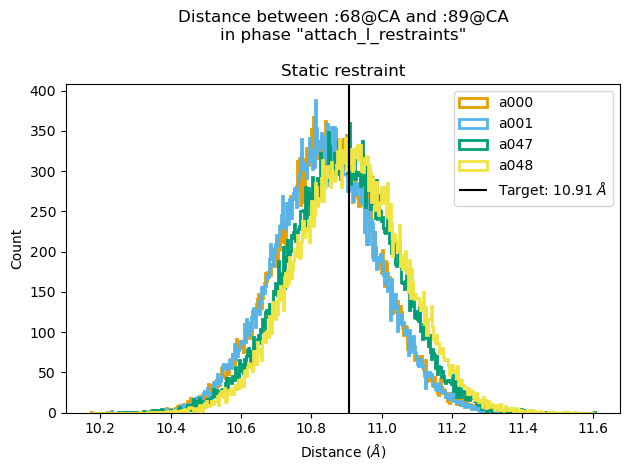

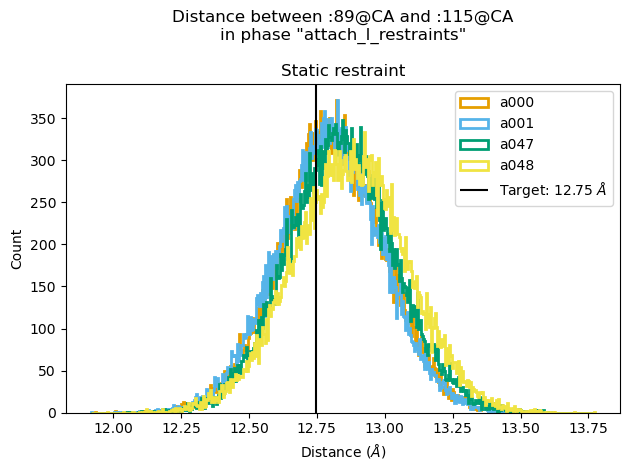

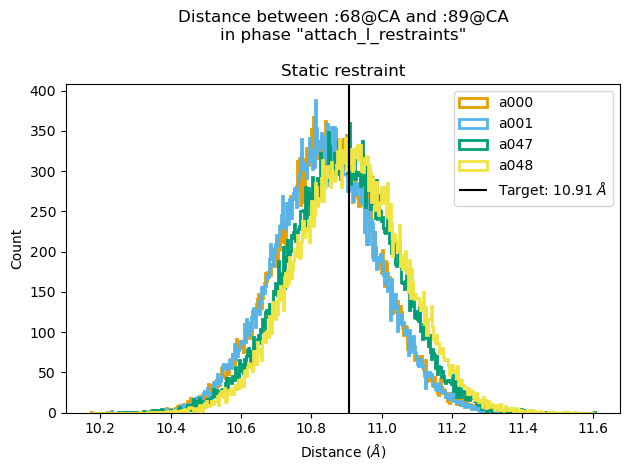

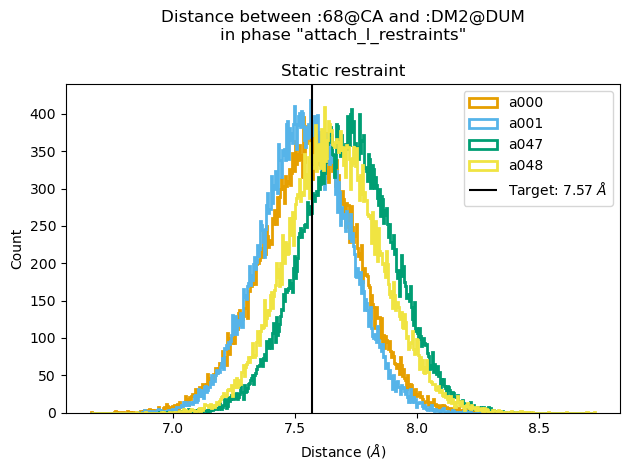

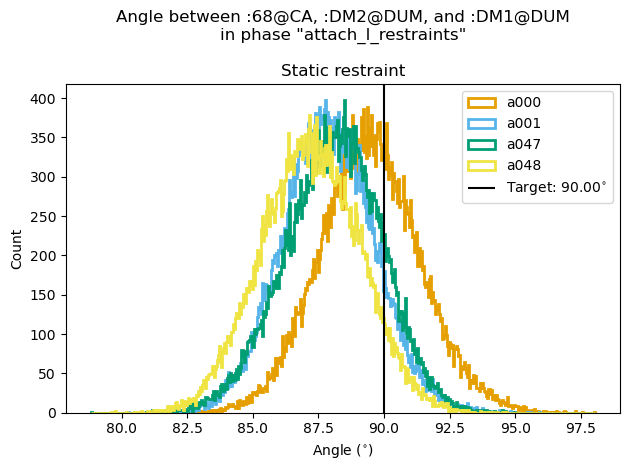

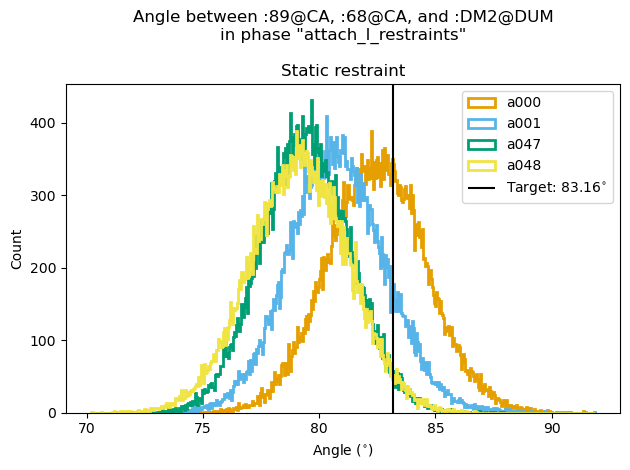

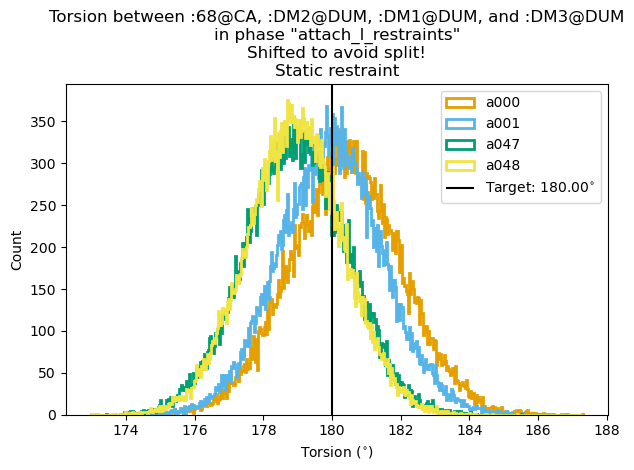

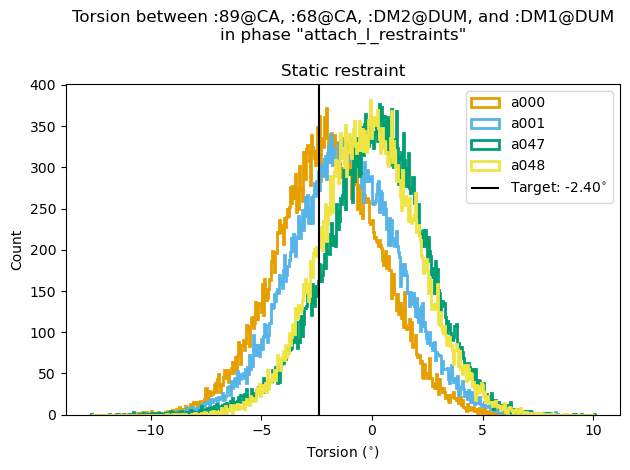

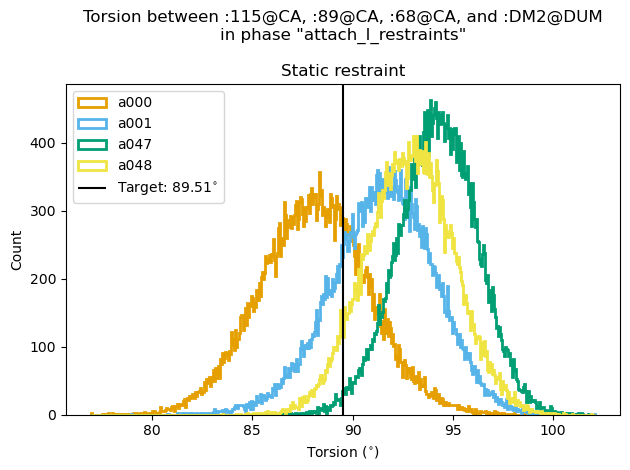

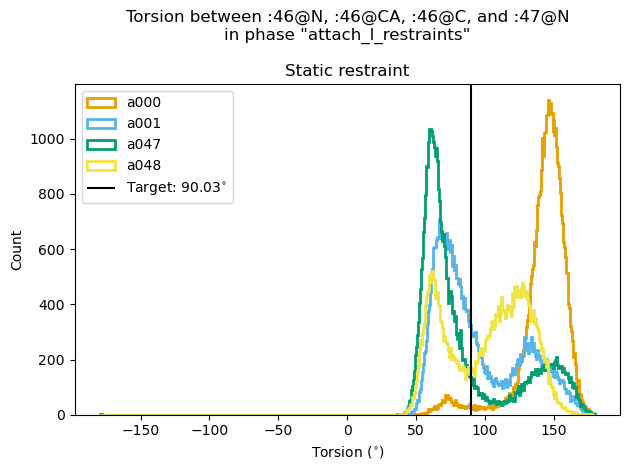

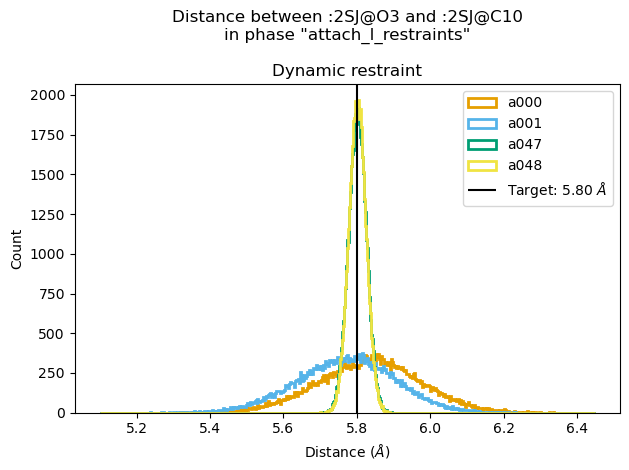

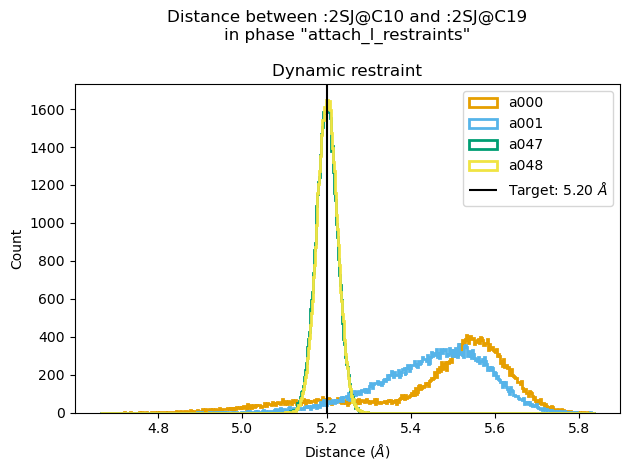

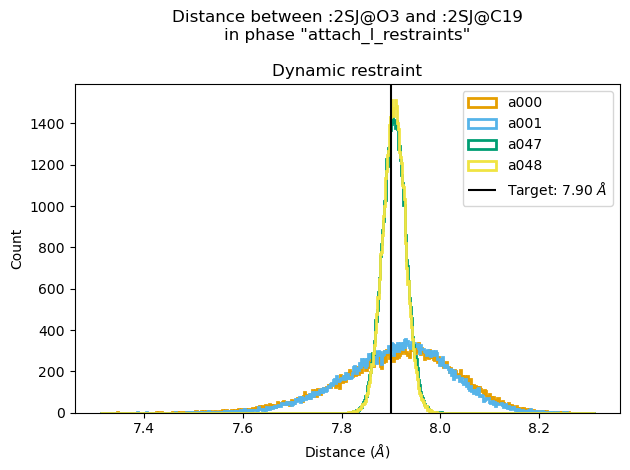

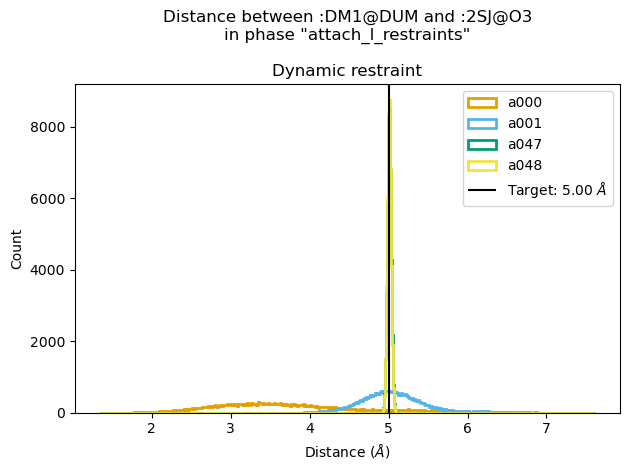

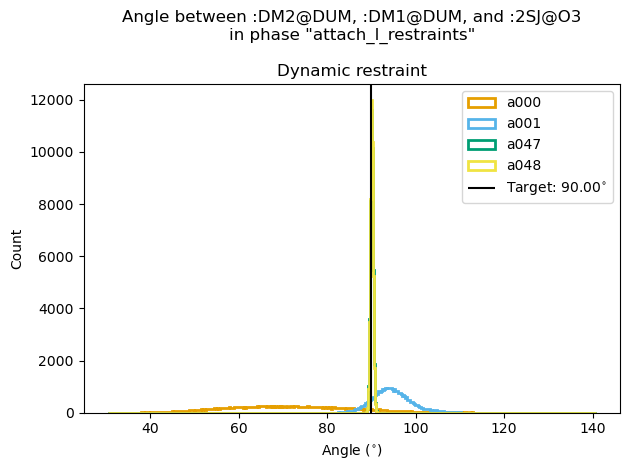

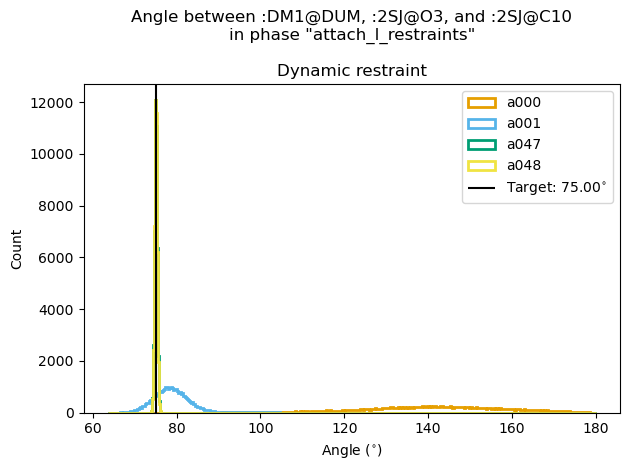

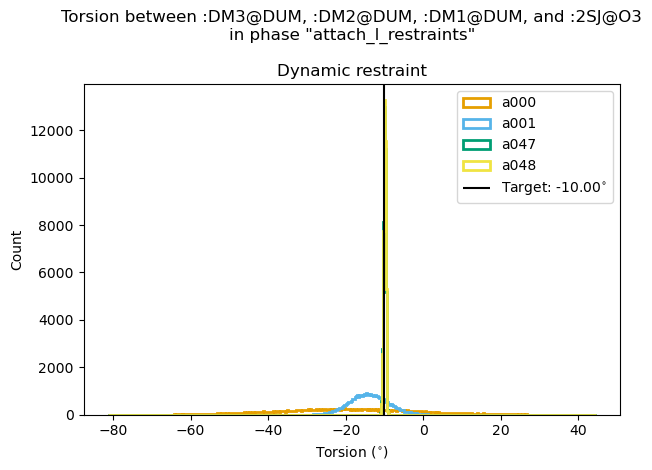

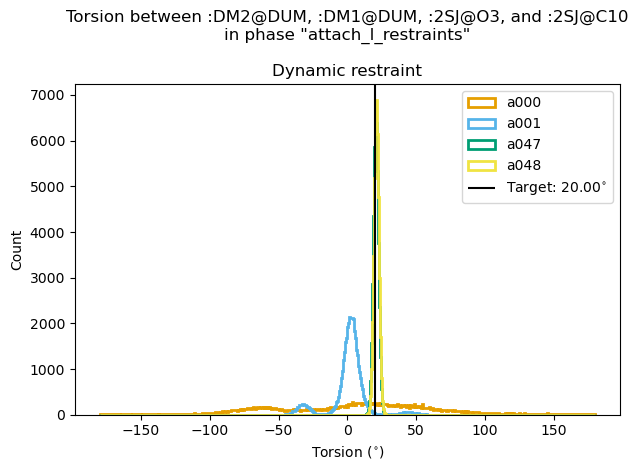

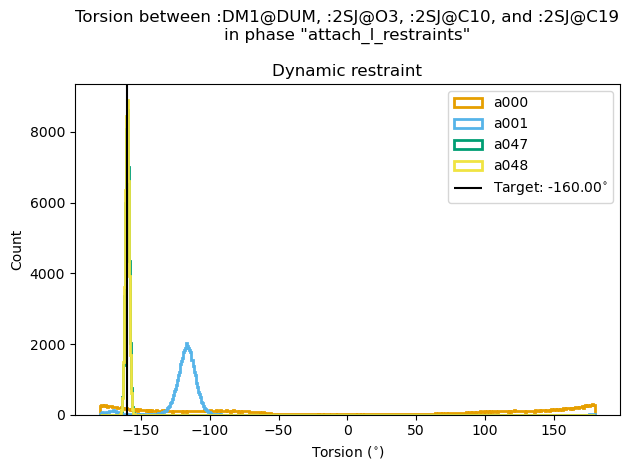

In [24]:
# from analyze import generate_histograms

# data_dir_names["working_data"] = "/data/ucsd/gilsonlab/jta002/OBC2/results_OBC2_replicate3/working_data"
# _ = generate_histograms(attach_l_restraints_static + attach_l_restraints_dynamic, "attach_l_restraints", [window_list[i] for i in [0, 1, -2, -1]], aligned_dummy_structure, data_dir_names)

    

In [19]:
from simulate import run_heating_and_equil, run_minimization, run_production

simulation_parameters = {
    "k_pos": 50 * kilocalorie / (mole * angstrom**2),
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
    "tolerance": 0.5 * kilojoules_per_mole / nanometer,
    "maxIterations": 0,
}

futures = [
   run_minimization.remote(
       window,
       system,
       model,
       attach_l_restraints_static + attach_l_restraints_dynamic,
       "attach_l_restraints",
       simulation_parameters=simulation_parameters,
       data_dir_names=data_dir_names,
   )
   for window in window_list
]
_ = ray.get(futures)


simulation_parameters = {
    "temperatures": np.arange(0.0, 298.15, 10.0),
    "time_per_temp": 20 * picoseconds,
    "equilibration_time": 15 * nanoseconds,
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
}

futures = [
   run_heating_and_equil.remote(
       window,
       system,
       model,
       "attach_l_restraints",
       simulation_parameters=simulation_parameters,
       data_dir_names=data_dir_names,
   )
   for window in window_list
]
_ = ray.get(futures)


simulation_parameters = {
    "temperature": 298.15,
    "friction": 1 / picosecond,
    "timestep": 2 * femtoseconds,
    "production_time": 25 * nanoseconds,
    "dcd_reporter_frequency": 1000,
    "state_reporter_frequency": 1000,
}

futures = [
   run_production.remote(
       window,
       system,
       model,
       "attach_l_restraints",
       simulation_parameters=simulation_parameters,
       data_dir_names=data_dir_names,
   )
   for window in window_list
]
_ = ray.get(futures)

In [20]:
import paprika.analysis as analysis
free_energy = analysis.fe_calc()
free_energy.topology = "heated.pdb"
free_energy.trajectory = "production.dcd"
free_energy.path = f"{working_data}/attach_l_restraints"
free_energy.restraint_list = attach_l_restraints_static + attach_l_restraints_dynamic
free_energy.collect_data(single_topology=False)
free_energy.methods = ["mbar-autoc"]
free_energy.boot_cycles = 1000
free_energy.compute_free_energy(phases=["attach"])
free_energy.save_results(f"{results_dirname}/deltaG_attach_l.json", overwrite=True)

deltaG_attach_l = {
   "fe": free_energy.results["attach"]["mbar-autoc"]["fe"],
   "sem": free_energy.results["attach"]["mbar-autoc"]["sem"],
   "fe_matrix": free_energy.results["attach"]["mbar-autoc"]["fe_matrix"],
   "sem_matrix": free_energy.results["attach"]["mbar-autoc"]["sem_matrix"],
}
deltaG_values["deltaG_attach_l"] = deltaG_attach_l
print("deltaG_attach_l", deltaG_attach_l)

2025-06-09 11:21:37 PM Failed to reach a solution to within tolerance with hybr: trying next method
2025-06-09 11:21:37 PM Ending gnorm of method hybr = 1.963470e+04
2025-06-09 11:21:37 PM Will continue with results from previous method
2025-06-09 11:21:38 PM Reached a solution to within tolerance with adaptive
2025-06-09 11:21:38 PM Solution found within tolerance!
2025-06-09 11:21:38 PM Final gradient norm: 2.75e-11
2025-06-09 11:21:40 PM Failed to reach a solution to within tolerance with hybr: trying next method
2025-06-09 11:21:40 PM Ending gnorm of method hybr = 1.963470e+04
2025-06-09 11:21:40 PM Will continue with results from previous method
2025-06-09 11:21:42 PM Reached a solution to within tolerance with adaptive
2025-06-09 11:21:42 PM Solution found within tolerance!
2025-06-09 11:21:42 PM Final gradient norm: 2.75e-11


deltaG_attach_l {'fe': <Quantity(28.8804418, 'kilocalorie / mole')>, 'sem': <Quantity(0.05550518, 'kilocalorie / mole')>, 'fe_matrix': <Quantity([[  0.           3.39968442   4.9135062  ...  28.52221919  28.70178882
   28.88044181]
 [ -3.39968442   0.           1.51382178 ...  25.12253477  25.3021044
   25.48075739]
 [ -4.9135062   -1.51382178   0.         ...  23.60871299  23.78828262
   23.96693561]
 ...
 [-28.52221919 -25.12253477 -23.60871299 ...   0.           0.17956963
    0.35822262]
 [-28.70178882 -25.3021044  -23.78828262 ...  -0.17956963   0.
    0.17865299]
 [-28.88044181 -25.48075739 -23.96693561 ...  -0.35822262  -0.17865299
    0.        ]], 'kilocalorie / mole')>, 'sem_matrix': <Quantity([[0.         0.03538265 0.04291279 ... 0.05537361 0.05543751 0.05550518]
 [0.03538265 0.         0.01423578 ... 0.03739179 0.03748636 0.03758636]
 [0.04291279 0.01423578 0.         ... 0.03240014 0.03250923 0.03262448]
 ...
 [0.05537361 0.03739179 0.03240014 ... 0.         0.0006858  0.

In [21]:
# import importlib
# import analyze
# from analyze import generate_histograms
# importlib.reload(analyze)  

# data = generate_histograms(attach_l_restraints_static[:]+attach_l_restraints_dynamic[:], "attach_l_restraints", window_list[:], aligned_dummy_structure, data_dir_names)


## Calculate $\Delta G_{pull}$

In [22]:
from paprika import restraints
from paprika.restraints.openmm import apply_dat_restraint, apply_positional_restraints

pull_distances = np.arange(D1_BOUND_VALUE.m_as(openff_unit.angstrom), 21 + 0.4, 0.4)

pull_restraints_static = []

# P1-P2-P3 distances, Asp88 ψ dihedral, D2, A3, A4, T4, T5, T6 (Fig. 1a)
P1_P2_distance = restraints.static_DAT_restraint(
    [P1, P2],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
P2_P3_distance = restraints.static_DAT_restraint(
    [P2, P3],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
P1_P3_distance = restraints.static_DAT_restraint(
    [P1, P2],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
Asp88_torsion = restraints.static_DAT_restraint(
    [ASP88_1, ASP88_2, ASP88_3, ASP88_4],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    20 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P1_N2_distance = restraints.static_DAT_restraint(
    [P1, N2],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
P1_N2_N1_angle = restraints.static_DAT_restraint(
    [P1, N2, N1],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P2_P1_N2_angle = restraints.static_DAT_restraint(
    [P2, P1, N2],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P1_N2_N1_N3_torsion = restraints.static_DAT_restraint(
    [P1, N2, N1, N3],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P2_P1_N2_N1_torsion = restraints.static_DAT_restraint(
    [P2, P1, N2, N1],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
P3_P2_P1_N2_torsion = restraints.static_DAT_restraint(
    [P3, P2, P1, N2],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)

Asp88_torsion_wall_static = restraints.static_DAT_restraint(
    [ASP88_1, ASP88_2, ASP88_3, ASP88_4],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure_protein_only.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
Asp88_torsion_wall_static.custom_restraint_values = {
    "r2": 55.0 * openff_unit.degree,
    "r3": 179.9,
    "rk2": 30.0 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    "rk3": 0.0,
}

pull_restraints_static += [
    P1_P2_distance,
    P2_P3_distance,
    P1_P3_distance,
    Asp88_torsion,
    P1_N2_distance,
    P1_N2_N1_angle,
    P2_P1_N2_angle,
    P1_N2_N1_N3_torsion,
    P2_P1_N2_N1_torsion,
    P3_P2_P1_N2_torsion,
    Asp88_torsion_wall_static,
]

# L1-L2-L3 distances, ligand dihedral when present (NOT PRESENT FOR THIS LIGAND), D1, A1, A2, T1, T2, T3 (Fig. 1a)
L1_L2_distance = restraints.static_DAT_restraint(
    [L1, L2],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
L2_L3_distance = restraints.static_DAT_restraint(
    [L2, L3],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
L1_L3_distance = restraints.static_DAT_restraint(
    [L1, L3],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    5 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.angstrom**2),
    continuous_apr=False,
)
N2_N1_L1_angle = restraints.static_DAT_restraint(
    [N2, N1, L1],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    10 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
N1_L1_L2_angle = restraints.static_DAT_restraint(
    [N1, L1, L2],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    10 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
N3_N2_N1_L1_torsion = restraints.static_DAT_restraint(
    [N3, N2, N1, L1],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    10 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
N2_N1_L1_L2_torsion = restraints.static_DAT_restraint(
    [N2, N1, L1, L2],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    10 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
N1_L1_L2_L3_torsion = restraints.static_DAT_restraint(
    [N2, N1, L1, L2],
    [0, len(pull_distances), 0],
    "prepared_data/aligned_dummy_structure.pdb",
    10 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)

pull_restraints_static += [
    L1_L2_distance,
    L2_L3_distance,
    L1_L3_distance,
    N2_N1_L1_angle,
    N1_L1_L2_angle,
    N3_N2_N1_L1_torsion,
    N2_N1_L1_L2_torsion,
    N1_L1_L2_L3_torsion,
]

pull_restraints_dynamic = []

# D1
N1_L1_distance = restraints.DAT_restraint()
N1_L1_distance.mask1 = N1
N1_L1_distance.mask2 = L1
N1_L1_distance.topology = aligned_dummy_structure
N1_L1_distance.auto_apr = False
N1_L1_distance.continuous_apr = False
N1_L1_distance.amber_index = False
N1_L1_distance.pull["fc"] = 5  # kilocalorie/(mole*angstrom**2)
# N1_L1_distance.pull["target_initial"] = D1_BOUND_VALUE
# N1_L1_distance.pull["target_final"] = 5
# N1_L1_distance.pull["target_increment"] = 0.4
N1_L1_distance.pull["target_list"] = pull_distances
N1_L1_distance.initialize()
pull_restraints_dynamic.append(N1_L1_distance)

# Check restraints and create windows from dynamic restraints
restraints.restraints.check_restraints(pull_restraints_static)
restraints.restraints.check_restraints(pull_restraints_dynamic)
window_list = restraints.utils.create_window_list(pull_restraints_dynamic)

2025-06-09 11:21:47 PM Restraints appear to be consistent
2025-06-09 11:21:47 PM Restraints appear to be consistent
2025-06-09 11:21:47 PM Restraints appear to be consistent


In [23]:
from simulate import run_heating_and_equil, run_minimization, run_production

simulation_parameters = {
   "k_pos": 50 * kilocalorie / (mole * angstrom**2),
   "friction": 1 / picosecond,
   "timestep": 1 * femtoseconds,
   "tolerance": 0.001 * kilojoules_per_mole / nanometer,
   "maxIterations": 0,
}

futures = [
   run_minimization.remote(
       window,
       system,
       model,
       pull_restraints_static + pull_restraints_dynamic,
       "pull_restraints",
       simulation_parameters=simulation_parameters,
       data_dir_names=data_dir_names,
   )
   for window in window_list
]
_ = ray.get(futures)


simulation_parameters = {
   "temperatures": np.arange(0.0, 298.15, 10.0),
   "time_per_temp": 20 * picoseconds,
   "equilibration_time": 15 * nanoseconds,
   "friction": 1 / picosecond,
   "timestep": 1 * femtoseconds,
}

futures = [
   run_heating_and_equil.remote(
       window,
       system,
       model,
       "pull_restraints",
       simulation_parameters=simulation_parameters,
       data_dir_names=data_dir_names,
   )
   for window in window_list
]
_ = ray.get(futures)


simulation_parameters = {
   "temperature": 298.15,
   "friction": 1 / picosecond,
   "timestep": 2 * femtoseconds,
   "production_time": 25 * nanoseconds,
   "dcd_reporter_frequency": 1000,
   "state_reporter_frequency": 1000,
}

futures = [
   run_production.remote(
       window,
       system,
       model,
       "pull_restraints",
       simulation_parameters=simulation_parameters,
       data_dir_names=data_dir_names,
   )
   for window in window_list
]
_ = ray.get(futures)

In [24]:
import paprika.analysis as analysis

free_energy = analysis.fe_calc()
free_energy.topology = "heated.pdb"
free_energy.trajectory = "production.dcd"
free_energy.path = f"{working_data}/pull_restraints"
free_energy.restraint_list = pull_restraints_static + pull_restraints_dynamic
free_energy.collect_data(single_topology=False)
free_energy.methods = ["mbar-autoc"]
free_energy.boot_cycles = 1000
free_energy.compute_free_energy(phases=["pull"])
free_energy.save_results(f"{results_dirname}/deltaG_pull.json", overwrite=True)

deltaG_pull = {
   "fe": free_energy.results["pull"]["mbar-autoc"]["fe"],
   "sem": free_energy.results["pull"]["mbar-autoc"]["sem"],
   "fe_matrix": free_energy.results["pull"]["mbar-autoc"]["fe_matrix"],
   "sem_matrix": free_energy.results["pull"]["mbar-autoc"]["sem_matrix"],
}
deltaG_values["deltaG_pull"] = deltaG_pull
print("deltaG_pull", deltaG_pull)

2025-06-09 11:21:50 PM Reached a solution to within tolerance with hybr
2025-06-09 11:21:50 PM Solution found within tolerance!
2025-06-09 11:21:50 PM Final gradient norm: 4.47e-08
2025-06-09 11:21:51 PM Reached a solution to within tolerance with hybr
2025-06-09 11:21:51 PM Solution found within tolerance!
2025-06-09 11:21:51 PM Final gradient norm: 4.47e-08


deltaG_pull {'fe': <Quantity(9.66448569, 'kilocalorie / mole')>, 'sem': <Quantity(0.272524596, 'kilocalorie / mole')>, 'fe_matrix': <Quantity([[ 0.00000000e+00  3.40329198e-02  2.87923276e-02 ...  8.85839212e+00
   9.27795271e+00  9.66448569e+00]
 [-3.40329198e-02  0.00000000e+00 -5.24059217e-03 ...  8.82435920e+00
   9.24391979e+00  9.63045277e+00]
 [-2.87923276e-02  5.24059217e-03  0.00000000e+00 ...  8.82959979e+00
   9.24916038e+00  9.63569336e+00]
 ...
 [-8.85839212e+00 -8.82435920e+00 -8.82959979e+00 ...  0.00000000e+00
   4.19560596e-01  8.06093570e-01]
 [-9.27795271e+00 -9.24391979e+00 -9.24916038e+00 ... -4.19560596e-01
   0.00000000e+00  3.86532974e-01]
 [-9.66448569e+00 -9.63045277e+00 -9.63569336e+00 ... -8.06093570e-01
  -3.86532974e-01  0.00000000e+00]], 'kilocalorie / mole')>, 'sem_matrix': <Quantity([[0.         0.02814671 0.05239301 ... 0.2650165  0.26858815 0.2725246 ]
 [0.02814671 0.         0.03035768 ... 0.26117342 0.26479691 0.26878889]
 [0.05239301 0.03035768 0. 

## Calculate $\Delta G_{release,l}$

In [25]:
# We only need to simulate the ligand

from paprika.build import align

openff_topology = openffTopology.from_molecules(molecules=[ligand_mol])
system = force_field.create_openmm_system(
    openff_topology,
    partial_bond_orders_from_molecules=[ligand_mol],
    charge_from_molecules=[ligand_mol],
    allow_nonintegral_charges=True,
)

add_CustomGB_force(FF_TO_USE, system)

openmm_positions = Quantity(
    value=[
        Vec3(
            pos[0].m_as(openff_unit.nanometer),
            pos[1].m_as(openff_unit.nanometer),
            pos[2].m_as(openff_unit.nanometer),
        )
        for pos in openff_topology.get_positions()
    ],
    unit=nanometer,
)
model = Modeller(
    openff_topology.to_openmm(ensure_unique_atom_names=False), openmm_positions
)

with open(f"{prepared_data}/aligned_structure.pickle", "rb") as f:
    structure = pickle.load(f)

structure.strip("!:2SJ")

model = Modeller(model.topology, structure.positions.in_units_of(nanometer))

In [26]:
# Give the dummy atoms mass of lead (207.2) and set the nonbonded forces for the dummy atoms to have charge 0 and LJ parameters epsilon=sigma=0.
for force in system.getForces():
    if isinstance(force, openmm.NonbondedForce):
        system.addParticle(mass=207.2)
        system.addParticle(mass=207.2)
        system.addParticle(mass=207.2)
        force.addParticle(0, 0, 0)
        force.addParticle(0, 0, 0)
        force.addParticle(0, 0, 0)
    if isinstance(force, openmm.CustomGBForce):
        force.addParticle([0, 0.15, 0.7, 0])
        force.addParticle([0, 0.15, 0.7, 0])
        force.addParticle([0, 0.15, 0.7, 0])

with open(f"{prepared_data}/aligned_dummy_system_ligand_only.xml", "w") as f:
    f.write(XmlSerializer.serialize(system))

all_positions = model.positions
all_positions.append(N1_pos)
all_positions.append(N2_pos)
all_positions.append(N3_pos)

chain = model.topology.addChain("5")
dummy_res1 = model.topology.addResidue(name="DM1", chain=chain)
dummy_res2 = model.topology.addResidue(name="DM2", chain=chain)
dummy_res3 = model.topology.addResidue(name="DM3", chain=chain)

model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res1)
model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res2)
model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res3)

with open(f"{prepared_data}/aligned_dummy_structure_ligand_only.cif", "w+") as f:
    PDBxFile.writeFile(model.topology, all_positions, file=f, keepIds=True)
with open(f"{prepared_data}/aligned_dummy_structure_ligand_only.pdb", "w+") as f:
    PDBFile.writeFile(model.topology, all_positions, file=f, keepIds=True)

aligned_dummy_structure = pmd.openmm.load_topology(
    model.topology, system, xyz=all_positions, condense_atom_types=False
)

In [27]:
from paprika import restraints
from paprika.restraints.openmm import apply_dat_restraint, apply_positional_restraints

release_l_fractions = attach_l_fractions[::-1]
print(release_l_fractions)

# L1-L2-L3 distances, ligand dihedral when present (NOT PRESENT FOR THIS LIGAND), D1, A1, A2, T1, T2, T3 (Fig. 1a)
release_l_restraints_dynamic = []

# L1-L2
L1_L2_distance = restraints.DAT_restraint()
L1_L2_distance.mask1 = L1
L1_L2_distance.mask2 = L2
L1_L2_distance.topology = aligned_dummy_structure
L1_L2_distance.auto_apr = False
L1_L2_distance.continuous_apr = False
L1_L2_distance.amber_index = False
L1_L2_vector = (
    aligned_dummy_structure[L2].positions[0] - aligned_dummy_structure[L1].positions[0]
)
L1_L2_vector = [val.value_in_unit(angstrom) for val in L1_L2_vector]
# L1_L2_distance.release["target"] = openff_unit.Quantity(
#     value=np.linalg.norm(L1_L2_vector), units=openff_unit.angstrom
# )
L1_L2_distance.release["target"] = openff_unit.Quantity(value=6.44443786813187, units=openff_unit.angstrom)
L1_L2_distance.release["fraction_list"] = release_l_fractions * 100
L1_L2_distance.release["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
L1_L2_distance.initialize()
release_l_restraints_dynamic.append(L1_L2_distance)

# L2-L3
L2_L3_distance = restraints.DAT_restraint()
L2_L3_distance.mask1 = L2
L2_L3_distance.mask2 = L3
L2_L3_distance.topology = aligned_dummy_structure
L2_L3_distance.auto_apr = False
L2_L3_distance.continuous_apr = False
L2_L3_distance.amber_index = False
L2_L3_vector = (
    aligned_dummy_structure[L3].positions[0] - aligned_dummy_structure[L2].positions[0]
)
L2_L3_vector = [val.value_in_unit(angstrom) for val in L2_L3_vector]
# L2_L3_distance.release["target"] = openff_unit.Quantity(
#     value=np.linalg.norm(L2_L3_vector), units=openff_unit.angstrom
# )
L2_L3_distance.release["target"] = openff_unit.Quantity(value=5.4634763006993, units=openff_unit.angstrom)
L2_L3_distance.release["fraction_list"] = release_l_fractions * 100
L2_L3_distance.release["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
L2_L3_distance.initialize()
release_l_restraints_dynamic.append(L2_L3_distance)

# L1-L3
L1_L3_distance = restraints.DAT_restraint()
L1_L3_distance.mask1 = L1
L1_L3_distance.mask2 = L3
L1_L3_distance.topology = aligned_dummy_structure
L1_L3_distance.auto_apr = False
L1_L3_distance.continuous_apr = False
L1_L3_distance.amber_index = False
L1_L3_vector = (
    aligned_dummy_structure[L3].positions[0] - aligned_dummy_structure[L1].positions[0]
)
L1_L3_vector = [val.value_in_unit(angstrom) for val in L1_L3_vector]
# L1_L3_distance.release["target"] = openff_unit.Quantity(
#     value=np.linalg.norm(L1_L3_vector), units=openff_unit.angstrom
# )
L1_L3_distance.release["target"] = openff_unit.Quantity(value=6.68343042057942, units=openff_unit.angstrom)
L1_L3_distance.release["fraction_list"] = release_l_fractions * 100
L1_L3_distance.release["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
L1_L3_distance.initialize()
release_l_restraints_dynamic.append(L1_L3_distance)

# # D1
# N1_L1_distance = restraints.DAT_restraint()
# N1_L1_distance.mask1 = N1
# N1_L1_distance.mask2 = L1
# N1_L1_distance.topology = aligned_dummy_structure
# N1_L1_distance.auto_apr = False
# N1_L1_distance.continuous_apr = False
# N1_L1_distance.amber_index = False
# N1_L1_vector = (
#     aligned_dummy_structure[L1].positions[0] - aligned_dummy_structure[N1].positions[0]
# )
# N1_L1_vector = [val.value_in_unit(angstrom) for val in N1_L1_vector]
# N1_L1_distance.release["target"] = openff_unit.Quantity(
#     value=np.linalg.norm(N1_L1_vector), units=openff_unit.angstrom
# )
# D1_BOUND_VALUE = openff_unit.Quantity(
#     value=np.linalg.norm(N1_L1_vector), units=openff_unit.angstrom
# )  # This should be very close to 5A
# N1_L1_distance.release["fraction_list"] = release_l_fractions * 100
# N1_L1_distance.release["fc_final"] = 5*2  # kilocalorie/(mole*angstrom**2)
# N1_L1_distance.initialize()
# release_l_restraints_dynamic.append(N1_L1_distance)

# # A1
# N2_N1_L1_angle = restraints.DAT_restraint()
# N2_N1_L1_angle.mask1 = N2
# N2_N1_L1_angle.mask2 = N1
# N2_N1_L1_angle.mask3 = L1
# N2_N1_L1_angle.topology = aligned_dummy_structure
# N2_N1_L1_angle.auto_apr = False
# N2_N1_L1_angle.continuous_apr = False
# N2_N1_L1_angle.amber_index = False
# N1_N2_vector = np.array(
#     aligned_dummy_structure[N2].positions[0].value_in_unit(angstrom)
# ) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
# N1_L1_vector = np.array(
#     aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom)
# ) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
# N2_N1_L1_angle.release["target"] = np.degrees(
#     np.arccos(
#         np.dot(N1_N2_vector, N1_L1_vector)
#         / (np.linalg.norm(N1_N2_vector) * np.linalg.norm(N1_L1_vector))
#     )
# )  # Degrees
# N2_N1_L1_angle.release["fraction_list"] = release_l_fractions * 100
# N2_N1_L1_angle.release["fc_final"] = 100  # kilocalorie/(mole*radian**2)
# N2_N1_L1_angle.initialize()
# release_l_restraints_dynamic.append(N2_N1_L1_angle)

# # A2
# N1_L1_L2_angle = restraints.DAT_restraint()
# N1_L1_L2_angle.mask1 = N1
# N1_L1_L2_angle.mask2 = L1
# N1_L1_L2_angle.mask3 = L2
# N1_L1_L2_angle.topology = aligned_dummy_structure
# N1_L1_L2_angle.auto_apr = False
# N1_L1_L2_angle.continuous_apr = False
# N1_L1_L2_angle.amber_index = False
# L1_N1_vector = np.array(
#     aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom)
# ) - np.array(aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom))
# L1_L2_vector = np.array(
#     aligned_dummy_structure[L2].positions[0].value_in_unit(angstrom)
# ) - np.array(aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom))
# N1_L1_L2_angle.release["target"] = np.degrees(
#     np.arccos(
#         np.dot(L1_N1_vector, L1_L2_vector)
#         / (np.linalg.norm(L1_N1_vector) * np.linalg.norm(L1_L2_vector))
#     )
# )  # Degrees
# N1_L1_L2_angle.release["fraction_list"] = release_l_fractions * 100
# N1_L1_L2_angle.release["fc_final"] = 100  # kilocalorie/(mole*radian**2)
# N1_L1_L2_angle.initialize()
# release_l_restraints_dynamic.append(N1_L1_L2_angle)

# # T1
# N3_N2_N1_L1_torsion = restraints.DAT_restraint()
# N3_N2_N1_L1_torsion.mask1 = N3
# N3_N2_N1_L1_torsion.mask2 = N2
# N3_N2_N1_L1_torsion.mask3 = N1
# N3_N2_N1_L1_torsion.mask4 = L1
# N3_N2_N1_L1_torsion.topology = aligned_dummy_structure
# N3_N2_N1_L1_torsion.auto_apr = False
# N3_N2_N1_L1_torsion.continuous_apr = False
# N3_N2_N1_L1_torsion.amber_index = False
# N3_N2_vector = np.array(
#     aligned_dummy_structure[N2].positions[0].value_in_unit(angstrom)
# ) - np.array(aligned_dummy_structure[N3].positions[0].value_in_unit(angstrom))
# N2_N1_vector = np.array(
#     aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom)
# ) - np.array(aligned_dummy_structure[N2].positions[0].value_in_unit(angstrom))
# N1_L1_vector = np.array(
#     aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom)
# ) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
# norm1, norm2 = np.cross(N3_N2_vector, N2_N1_vector), np.cross(
#     N2_N1_vector, N1_L1_vector
# )
# N3_N2_N1_L1_torsion.release["target"] = np.degrees(
#     np.arccos(np.dot(norm1, norm2) / (np.linalg.norm(norm1) * np.linalg.norm(norm2)))
# )
# N3_N2_N1_L1_torsion.release["fraction_list"] = release_l_fractions * 100
# N3_N2_N1_L1_torsion.release["fc_final"] = 100  # kilocalorie/(mole*radian**2)
# N3_N2_N1_L1_torsion.initialize()
# release_l_restraints_dynamic.append(N3_N2_N1_L1_torsion)

# # T2
# N2_N1_L1_L2_torsion = restraints.DAT_restraint()
# N2_N1_L1_L2_torsion.mask1 = N2
# N2_N1_L1_L2_torsion.mask2 = N1
# N2_N1_L1_L2_torsion.mask3 = L1
# N2_N1_L1_L2_torsion.mask4 = L2
# N2_N1_L1_L2_torsion.topology = aligned_dummy_structure
# N2_N1_L1_L2_torsion.auto_apr = False
# N2_N1_L1_L2_torsion.continuous_apr = False
# N2_N1_L1_L2_torsion.amber_index = False
# N2_N1_vector = np.array(
#     aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom)
# ) - np.array(aligned_dummy_structure[N2].positions[0].value_in_unit(angstrom))
# N1_L1_vector = np.array(
#     aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom)
# ) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
# L1_L2_vector = np.array(
#     aligned_dummy_structure[L2].positions[0].value_in_unit(angstrom)
# ) - np.array(aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom))
# norm1, norm2 = np.cross(N2_N1_vector, N1_L1_vector), np.cross(
#     N1_L1_vector, L1_L2_vector
# )
# N2_N1_L1_L2_torsion.release["target"] = np.degrees(
#     np.arccos(np.dot(norm1, norm2) / (np.linalg.norm(norm1) * np.linalg.norm(norm2)))
# )
# N2_N1_L1_L2_torsion.release["fraction_list"] = release_l_fractions * 100
# N2_N1_L1_L2_torsion.release["fc_final"] = 100  # kilocalorie/(mole*radian**2)
# N2_N1_L1_L2_torsion.initialize()
# release_l_restraints_dynamic.append(N2_N1_L1_L2_torsion)

# # T3
# N1_L1_L2_L3_torsion = restraints.DAT_restraint()
# N1_L1_L2_L3_torsion.mask1 = N1
# N1_L1_L2_L3_torsion.mask2 = L1
# N1_L1_L2_L3_torsion.mask3 = L2
# N1_L1_L2_L3_torsion.mask4 = L3
# N1_L1_L2_L3_torsion.topology = aligned_dummy_structure
# N1_L1_L2_L3_torsion.auto_apr = False
# N1_L1_L2_L3_torsion.continuous_apr = False
# N1_L1_L2_L3_torsion.amber_index = False
# N1_L1_vector = np.array(
#     aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom)
# ) - np.array(aligned_dummy_structure[N1].positions[0].value_in_unit(angstrom))
# L1_L2_vector = np.array(
#     aligned_dummy_structure[L2].positions[0].value_in_unit(angstrom)
# ) - np.array(aligned_dummy_structure[L1].positions[0].value_in_unit(angstrom))
# L2_L3_vector = np.array(
#     aligned_dummy_structure[L3].positions[0].value_in_unit(angstrom)
# ) - np.array(aligned_dummy_structure[L2].positions[0].value_in_unit(angstrom))
# norm1, norm2 = np.cross(N1_L1_vector, L1_L2_vector), np.cross(
#     L1_L2_vector, L2_L3_vector
# )
# N1_L1_L2_L3_torsion.release["target"] = np.degrees(
#     np.arccos(np.dot(norm1, norm2) / (np.linalg.norm(norm1) * np.linalg.norm(norm2)))
# )
# N1_L1_L2_L3_torsion.release["fraction_list"] = release_l_fractions * 100
# N1_L1_L2_L3_torsion.release["fc_final"] = 100
# N1_L1_L2_L3_torsion.initialize()
# release_l_restraints_dynamic.append(N1_L1_L2_L3_torsion)


# Check restraints and create windows from dynamic restraints
restraints.restraints.check_restraints(release_l_restraints_dynamic)
window_list = restraints.utils.create_window_list(release_l_restraints_dynamic)

2025-06-09 11:21:52 PM Restraints appear to be consistent
2025-06-09 11:21:52 PM Restraints appear to be consistent


[1.         0.93623857 0.87634025 ... 0.00697641 0.00337923 0.        ]


In [28]:
from simulate import run_heating_and_equil, run_minimization, run_production

simulation_parameters = {
    "k_pos": 50 * kilocalorie / (mole * angstrom**2),
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
    "tolerance": 0.0001 * kilojoules_per_mole / nanometer,
    "maxIterations": 0,
}

futures = [
   run_minimization.remote(
       window,
       system,
       model,
       release_l_restraints_dynamic,
       "release_l_restraints",
       simulation_parameters=simulation_parameters,
       data_dir_names=data_dir_names,
       suffix="_ligand_only",
   )
   for window in window_list
]
_ = ray.get(futures)


simulation_parameters = {
    "temperatures": np.arange(0.0, 298.15, 10.0),
    "time_per_temp": 20 * picoseconds,
    "equilibration_time": 15 * nanoseconds,
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
}

futures = [
   run_heating_and_equil.remote(
       window,
       system,
       model,
       "release_l_restraints",
       simulation_parameters=simulation_parameters,
       data_dir_names=data_dir_names,
       suffix="_ligand_only",
   )
   for window in window_list
]
_ = ray.get(futures)


simulation_parameters = {
    "temperature": 298.15,
    "friction": 1 / picosecond,
    "timestep": 2 * femtoseconds,
    "production_time": 25 * nanoseconds,
    "dcd_reporter_frequency": 1000,
    "state_reporter_frequency": 1000,
}

futures = [
    run_production.remote(
        window,
        system,
        model,
        "release_l_restraints",
        simulation_parameters=simulation_parameters,
        data_dir_names=data_dir_names,
        suffix="_ligand_only",
    )
    for window in window_list
]
_ = ray.get(futures)

In [29]:
import paprika.analysis as analysis

free_energy = analysis.fe_calc()
free_energy.topology = "heated.pdb"
free_energy.trajectory = "production.dcd"
free_energy.path = f"{working_data}/release_l_restraints"
free_energy.restraint_list = release_l_restraints_dynamic
free_energy.collect_data(single_topology=False)
free_energy.methods = ["mbar-autoc"]
free_energy.boot_cycles = 1000
free_energy.compute_free_energy(phases=["release"])
free_energy.save_results(f"{results_dirname}/deltaG_release_l.json", overwrite=True)

deltaG_release_l = {
   "fe": free_energy.results["release"]["mbar-autoc"]["fe"],
   "sem": free_energy.results["release"]["mbar-autoc"]["sem"],
   "fe_matrix": free_energy.results["release"]["mbar-autoc"]["fe_matrix"],
   "sem_matrix": free_energy.results["release"]["mbar-autoc"]["sem_matrix"],
}
deltaG_values["deltaG_release_l"] = deltaG_release_l
print("deptaG_release_l", deltaG_release_l)

2025-06-09 11:21:56 PM Reached a solution to within tolerance with hybr
2025-06-09 11:21:56 PM Solution found within tolerance!
2025-06-09 11:21:56 PM Final gradient norm: 7.18e-08
2025-06-09 11:21:58 PM Reached a solution to within tolerance with hybr
2025-06-09 11:21:58 PM Solution found within tolerance!
2025-06-09 11:21:58 PM Final gradient norm: 7.18e-08


deptaG_release_l {'fe': <Quantity(20.9271096, 'kilocalorie / mole')>, 'sem': <Quantity(0.0450086625, 'kilocalorie / mole')>, 'fe_matrix': <Quantity([[  0.           3.07216945   5.69437183 ...  20.76862905  20.84858429
   20.9271096 ]
 [ -3.07216945   0.           2.62220238 ...  17.6964596   17.77641484
   17.85494015]
 [ -5.69437183  -2.62220238   0.         ...  15.07425723  15.15421247
   15.23273777]
 ...
 [-20.76862905 -17.6964596  -15.07425723 ...   0.           0.07995524
    0.15848054]
 [-20.84858429 -17.77641484 -15.15421247 ...  -0.07995524   0.
    0.07852531]
 [-20.9271096  -17.85494015 -15.23273777 ...  -0.15848054  -0.07852531
    0.        ]], 'kilocalorie / mole')>, 'sem_matrix': <Quantity([[0.         0.01127849 0.01981012 ... 0.04493065 0.04496935 0.04500866]
 [0.01127849 0.         0.01051805 ... 0.04113933 0.04118159 0.04122452]
 [0.01981012 0.01051805 0.         ... 0.03724953 0.0372962  0.03734359]
 ...
 [0.04493065 0.04113933 0.03724953 ... 0.         0.0003983

In [30]:
import paprika.analysis as analysis

GUEST_RESTRAINTS = [N1_L1_distance, N2_N1_L1_angle, N3_N2_N1_L1_torsion, N2_N1_L1_L2_torsion, N1_L1_L2_angle, N1_L1_L2_L3_torsion]

free_energy = analysis.fe_calc()
free_energy.compute_ref_state_work(GUEST_RESTRAINTS)
free_energy.save_results(f"{results_dirname}/deltaG_release_l_std.json", overwrite=True)

deltaG_release_l_std = {
   "fe": free_energy.results["ref_state_work"],
   "sem": 0.0,
}
deltaG_values["deltaG_release_l_std"] = deltaG_release_l_std
print("deltaG_release_l_std", deltaG_release_l_std)

/home/jta002/workspace/Beren_project/software/pAPRika/paprika/analysis/analysis.py:1359: UserWarning: Converting restraint list to dictionary, make sure the restraints are listed in the order of [`r`, `theta`,`phi`, `alpha`, `beta`, `gamma`].
  warnings.warn(


deltaG_release_l_std {'fe': <Quantity(-9.72831365, 'kilocalorie / mole')>, 'sem': 0.0}


## Calculate $\Delta G_{release,p}$

In [31]:
# We only need to simulate the protein

from paprika.build import align

openff_topology = openffTopology.from_molecules(molecules=[protein_mol])
interchange = force_field.create_interchange(
    openff_topology,
    partial_bond_orders_from_molecules=[protein_mol],
    charge_from_molecules=[protein_mol],
    allow_nonintegral_charges=True,
)
system = interchange.to_openmm_system(hydrogen_mass=3.024)

add_CustomGB_force(FF_TO_USE, system)

openmm_positions = Quantity(
    value=[
        Vec3(
            pos[0].m_as(openff_unit.nanometer),
            pos[1].m_as(openff_unit.nanometer),
            pos[2].m_as(openff_unit.nanometer),
        )
        for pos in openff_topology.get_positions()
    ],
    unit=nanometer,
)
model = Modeller(
    openff_topology.to_openmm(ensure_unique_atom_names=False), openmm_positions
)

# This is not the open conf, which is incorrect
with open(f"{prepared_data}/aligned_structure.pickle", "rb") as f:
    structure = pickle.load(f)

structure.strip(":2SJ")

model = Modeller(model.topology, structure.positions.in_units_of(nanometer))

In [32]:
# Give the dummy atoms mass of lead (207.2) and set the nonbonded forces for the dummy atoms to have charge 0 and LJ parameters epsilon=sigma=0.
for force in system.getForces():
    if isinstance(force, openmm.NonbondedForce):
        system.addParticle(mass=207.2)
        system.addParticle(mass=207.2)
        system.addParticle(mass=207.2)
        force.addParticle(0, 0, 0)
        force.addParticle(0, 0, 0)
        force.addParticle(0, 0, 0)
    if isinstance(force, openmm.CustomGBForce):
        force.addParticle([0, 0.15, 0.7, 0])
        force.addParticle([0, 0.15, 0.7, 0])
        force.addParticle([0, 0.15, 0.7, 0])

with open(f"{prepared_data}/aligned_dummy_system_protein_only.xml", "w") as f:
    f.write(XmlSerializer.serialize(system))

all_positions = model.positions
all_positions.append(N1_pos)
all_positions.append(N2_pos)
all_positions.append(N3_pos)

chain = model.topology.addChain("5")
dummy_res1 = model.topology.addResidue(name="DM1", chain=chain)
dummy_res2 = model.topology.addResidue(name="DM2", chain=chain)
dummy_res3 = model.topology.addResidue(name="DM3", chain=chain)

model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res1, id=500)
model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res2, id=501)
model.topology.addAtom("DUM", Element.getBySymbol("Pb"), dummy_res3, id=502)

with open(f"{prepared_data}/aligned_dummy_structure_protein_only.cif", "w+") as f:
    PDBxFile.writeFile(model.topology, all_positions, file=f, keepIds=True)
with open(f"{prepared_data}/aligned_dummy_structure_protein_only.pdb", "w+") as f:
    PDBFile.writeFile(model.topology, all_positions, file=f, keepIds=True)

aligned_dummy_structure = pmd.openmm.load_topology(
    model.topology, system, xyz=all_positions, condense_atom_types=False
)

In [33]:
from paprika import restraints
from paprika.restraints.openmm import apply_dat_restraint, apply_positional_restraints

from openmm.app import PDBFile

closed_conf_path = f"{prepared_data}/aligned_dummy_structure_protein_only.pdb"
pdb = PDBFile(closed_conf_path)
model.positions = pdb.positions
aligned_dummy_structure.positions = pdb.positions

release_p_fractions = attach_p_fractions[::-1]

release_p_restraints_static = []


Asp88_torsion_wall_static = restraints.static_DAT_restraint(
    [ASP88_1, ASP88_2, ASP88_3, ASP88_4],
    [0, 0, len(release_p_fractions)],
    "prepared_data/aligned_dummy_structure.pdb",
    100 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    continuous_apr=False,
)
Asp88_torsion_wall_static.custom_restraint_values = {
    "r2": 55.0 * openff_unit.degree,
    "r3": 179.9,
    "rk2": 30.0 * openff_unit.kilocalorie / (openff_unit.mole * openff_unit.radian**2),
    "rk3": 0.0,
}

release_p_restraints_static.append(Asp88_torsion_wall_static)

release_p_restraints_dynamic = []


P1_P2_distance = restraints.DAT_restraint()
P1_P2_distance.mask1 = P1
P1_P2_distance.mask2 = P2
P1_P2_distance.topology = aligned_dummy_structure
P1_P2_distance.auto_apr = False
P1_P2_distance.continuous_apr = False
P1_P2_distance.amber_index = False
P1_P2_vector = (
    aligned_dummy_structure[P2].positions[0] - aligned_dummy_structure[P1].positions[0]
)
P1_P2_vector = [val.value_in_unit(angstrom) for val in P1_P2_vector]
P1_P2_distance.release["target"] = openff_unit.Quantity(
    value=np.linalg.norm(P1_P2_vector), units=openff_unit.angstrom
)
P1_P2_distance.release["fraction_list"] = release_p_fractions * 100
P1_P2_distance.release["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
P1_P2_distance.initialize()

release_p_restraints_dynamic.append(P1_P2_distance)


P2_P3_distance = restraints.DAT_restraint()
P2_P3_distance.mask1 = P2
P2_P3_distance.mask2 = P3
P2_P3_distance.topology = aligned_dummy_structure
P2_P3_distance.auto_apr = False
P2_P3_distance.continuous_apr = False
P2_P3_distance.amber_index = False
P2_P3_vector = (
    aligned_dummy_structure[P3].positions[0] - aligned_dummy_structure[P2].positions[0]
)
P2_P3_vector = [val.value_in_unit(angstrom) for val in P2_P3_vector]
P2_P3_distance.release["target"] = openff_unit.Quantity(
    value=np.linalg.norm(P2_P3_vector), units=openff_unit.angstrom
)
P2_P3_distance.release["fraction_list"] = release_p_fractions * 100
P2_P3_distance.release["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
P2_P3_distance.initialize()

release_p_restraints_dynamic.append(P2_P3_distance)


P1_P3_distance = restraints.DAT_restraint()
P1_P3_distance.mask1 = P1
P1_P3_distance.mask2 = P3
P1_P3_distance.topology = aligned_dummy_structure
P1_P3_distance.auto_apr = False
P1_P3_distance.continuous_apr = False
P1_P3_distance.amber_index = False
P1_P3_vector = (
    aligned_dummy_structure[P3].positions[0] - aligned_dummy_structure[P1].positions[0]
)
P1_P3_vector = [val.value_in_unit(angstrom) for val in P1_P3_vector]
P1_P3_distance.release["target"] = openff_unit.Quantity(
    value=np.linalg.norm(P1_P3_vector), units=openff_unit.angstrom
)
P1_P3_distance.release["fraction_list"] = release_p_fractions * 100
P1_P3_distance.release["fc_final"] = 5  # kilocalorie/(mole*angstrom**2)
P1_P3_distance.initialize()

release_p_restraints_dynamic.append(P1_P3_distance)


Asp88_torsion = restraints.DAT_restraint()
Asp88_torsion.mask1 = ASP88_1
Asp88_torsion.mask2 = ASP88_2
Asp88_torsion.mask3 = ASP88_3
Asp88_torsion.mask4 = ASP88_4
Asp88_torsion.topology = aligned_dummy_structure
Asp88_torsion.auto_apr = False
Asp88_torsion.continuous_apr = False
Asp88_torsion.amber_index = False
Asp88_torsion.release["target"] = 80  # Degrees
Asp88_torsion.release["fraction_list"] = release_p_fractions * 100
Asp88_torsion.release["fc_final"] = 30  # kilocalorie/(mole*radian**2)
Asp88_torsion.initialize()

release_p_restraints_dynamic.append(Asp88_torsion)


# Check restraints and create windows from dynamic restraints
restraints.restraints.check_restraints(release_p_restraints_static)
restraints.restraints.check_restraints(release_p_restraints_dynamic)
window_list = restraints.utils.create_window_list(release_p_restraints_dynamic)

2025-06-09 11:22:14 PM Restraints appear to be consistent
2025-06-09 11:22:14 PM Restraints appear to be consistent
2025-06-09 11:22:14 PM Restraints appear to be consistent


In [34]:
from simulate import run_heating_and_equil, run_minimization, run_production

simulation_parameters = {
    "k_pos": 50 * kilocalorie / (mole * angstrom**2),
    "friction": 1 / picosecond,
    "timestep": 1 * femtoseconds,
    "tolerance": 0.001 * kilojoules_per_mole / nanometer,
    "maxIterations": 0,
}

futures = [
    run_minimization.remote(
        window,
        system,
        model,
        release_p_restraints_dynamic,
        "release_p_restraints",
        simulation_parameters=simulation_parameters,
        data_dir_names=data_dir_names,
        suffix="_protein_only",
    )
    for window in window_list
]
_ = ray.get(futures)

simulation_parameters = {
    "temperatures": np.arange(0.0, 298.15, 1.0),
    "time_per_temp": 20 * picoseconds,
    "equilibration_time": 15 * nanoseconds,
    "friction": 1 / picosecond,
    "timestep": 0.5 * femtoseconds,
}

futures = [
    run_heating_and_equil.remote(
        window,
        system,
        model,
        "release_p_restraints",
        simulation_parameters=simulation_parameters,
        data_dir_names=data_dir_names,
        suffix="_protein_only",
    )
    for window in window_list
]
_ = ray.get(futures)

simulation_parameters = {
    "temperature": 298.15,
    "friction": 1 / picosecond,
    "timestep": 2 * femtoseconds,
    "production_time": 25 * nanoseconds,
    "dcd_reporter_frequency": 1000,
    "state_reporter_frequency": 1000,
    "suffix": "_protein_only",
}

futures = [
    run_production.remote(
        window,
        system,
        model,
        "release_p_restraints",
        simulation_parameters=simulation_parameters,
        data_dir_names=data_dir_names,
        suffix="_protein_only",
    )
    for window in window_list
]
_ = ray.get(futures)

In [35]:
import paprika.analysis as analysis

free_energy = analysis.fe_calc()
free_energy.topology = "heated.pdb"
free_energy.trajectory = "production.dcd"
free_energy.path = f"{working_data}/release_p_restraints"
free_energy.restraint_list = release_p_restraints_dynamic
free_energy.collect_data(single_topology=False)
free_energy.methods = ["mbar-autoc"]
free_energy.boot_cycles = 1000
free_energy.compute_free_energy(phases=["release"])
free_energy.save_results(f"{results_dirname}/deltaG_release_p.json", overwrite=True)

deltaG_release_p = {
   "fe": -1*free_energy.results["release"]["mbar-autoc"]["fe"],  # -1 coeff because of fraction ordering and because we use it directly in sum
   "sem": free_energy.results["release"]["mbar-autoc"]["sem"],
   "fe_matrix": free_energy.results["release"]["mbar-autoc"]["fe_matrix"],
   "sem_matrix": free_energy.results["release"]["mbar-autoc"]["sem_matrix"],
}
deltaG_values["deltaG_release_p"] = deltaG_release_p
print("deltaG_release_p", deltaG_release_p)

2025-06-09 11:22:16 PM Reached a solution to within tolerance with hybr
2025-06-09 11:22:16 PM Solution found within tolerance!
2025-06-09 11:22:16 PM Final gradient norm: 6.72e-09
2025-06-09 11:22:16 PM Reached a solution to within tolerance with hybr
2025-06-09 11:22:16 PM Solution found within tolerance!
2025-06-09 11:22:16 PM Final gradient norm: 6.72e-09


deltaG_release_p {'fe': <Quantity(-6.23492478, 'kilocalorie / mole')>, 'sem': <Quantity(0.108790133, 'kilocalorie / mole')>, 'fe_matrix': <Quantity([[ 0.          2.0747258   2.61976689 ...  5.99925925  6.11770353
   6.23492478]
 [-2.0747258   0.          0.54504109 ...  3.92453345  4.04297773
   4.16019898]
 [-2.61976689 -0.54504109  0.         ...  3.37949236  3.49793664
   3.61515789]
 ...
 [-5.99925925 -3.92453345 -3.37949236 ...  0.          0.11844428
   0.23566553]
 [-6.11770353 -4.04297773 -3.49793664 ... -0.11844428  0.
   0.11722125]
 [-6.23492478 -4.16019898 -3.61515789 ... -0.23566553 -0.11722125
   0.        ]], 'kilocalorie / mole')>, 'sem_matrix': <Quantity([[0.         0.09165519 0.09968975 ... 0.10845953 0.10862196 0.10879013]
 [0.09165519 0.         0.01708024 ... 0.04387389 0.0442739  0.04468492]
 [0.09968975 0.01708024 0.         ... 0.03517309 0.03567085 0.03617976]
 ...
 [0.10845953 0.04387389 0.03517309 ... 0.         0.00159111 0.00321776]
 [0.10862196 0.0442739

## Save the results

In [41]:
existing_results_path = f"/data/ucsd/gilsonlab/jta002/OBC2/results_OBC2_replicate1/results.pickle"

if os.path.exists(existing_results_path):
    with open(existing_results_path, "rb") as f:
       deltaG_values = pickle.load(f)

else:
    raise IOError

# with open(f"/data/ucsd/gilsonlab/jta002/results_5-18-25_Logistic/results.pickle", "wb") as f:
#    pickle.dump(deltaG_values, f)

In [37]:
deltaG_values["release_l"] = {}
deltaG_values["release_l"]["fe"] = -1*(deltaG_values["deltaG_release_l"]["fe"]  # The outer -1 coeff is there for same reason as release_p's
                                    + -1*deltaG_values["deltaG_release_l_std"]["fe"])
deltaG_values["release_l"]["sem"] = np.sqrt(deltaG_values["deltaG_release_l"]["sem"]**2
                                            + deltaG_values["deltaG_release_l_std"]["sem"]**2)

# deltaG_values["release_p"] = {}
# deltaG_values["release_p"]["fe"] = (deltaG_values["deltaG_attach_conf"]["fe"]
#                                     + deltaG_values["deltaG_pull_conf"]["fe"]
#                                     + deltaG_values["deltaG_release_conf"]["fe"])
# deltaG_values["release_p"]["sem"] = np.sqrt(deltaG_values["deltaG_attach_conf"]["sem"]**2
#                                             + deltaG_values["deltaG_pull_conf"]["sem"]**2
#                                             + deltaG_values["deltaG_release_conf"]["sem"]**2)


In [38]:
deltaG_values["total"] = {}
deltaG_values["total"]["fe"] = -1 * (deltaG_values["deltaG_attach_p"]["fe"]
                                + deltaG_values["deltaG_attach_l"]["fe"]
                                + deltaG_values["deltaG_pull"]["fe"]
                                + deltaG_values["release_l"]["fe"]
                                + deltaG_values["deltaG_release_p"]["fe"])
deltaG_values["total"]["sem"] = np.sqrt(deltaG_values["deltaG_attach_p"]["sem"]**2
                                       + deltaG_values["deltaG_attach_l"]["sem"]**2
                                       + deltaG_values["deltaG_pull"]["sem"]**2
                                       + deltaG_values["release_l"]["sem"]**2
                                       + deltaG_values["deltaG_release_p"]["sem"]**2)

In [42]:
for key in deltaG_values.keys():
    if key in ("deltaG_release_l", "deltaG_release_l_std"):
        continue
    print(f"{key}\nfe: {deltaG_values[key]['fe']:0.3f}\nsem: {deltaG_values[key]['sem']:0.3f}")
    try:
        print(f"First few window free energies: {[val.m.round(3) for val in deltaG_values[key]['fe_matrix'][0][:10]]*deltaG_values[key]['fe_matrix'][0][:10].units}\n")
    except:
        print("\n")

deltaG_attach_p
fe: 5.053 kilocalorie / mole
sem: 0.008 kilocalorie / mole
First few window free energies: [0.0 0.987 1.493 1.848 2.129 2.366 2.575 2.765 2.94 3.104] kilocalorie / mole

deltaG_attach_l
fe: 33.105 kilocalorie / mole
sem: 0.064 kilocalorie / mole
First few window free energies: [0.0 7.092 10.119 12.561 14.261 15.386 16.332 17.203 18.003 18.727] kilocalorie / mole

deltaG_pull
fe: 6.009 kilocalorie / mole
sem: 0.039 kilocalorie / mole
First few window free energies: [0.0 0.283 0.309 0.292 0.295 0.24 0.11 -0.115 -0.337 -0.576] kilocalorie / mole

deltaG_release_p
fe: -4.945 kilocalorie / mole
sem: 0.008 kilocalorie / mole
First few window free energies: [0.0 0.963 1.437 1.773 2.043 2.275 2.48 2.667 2.839 3.002] kilocalorie / mole

release_l
fe: -30.736 kilocalorie / mole
sem: 0.014 kilocalorie / mole


total
fe: -8.486 kilocalorie / mole
sem: 0.077 kilocalorie / mole




In [40]:
with open(f"{results_dirname}/results.pickle", "wb") as f:
   pickle.dump(deltaG_values, f)